# Demos for analyzing World Color Survey (WCS)

COG 260: Data, Computation, and The Mind (Yang Xu)

Data source: http://www1.icsi.berkeley.edu/wcs/data.html

______________________________________________

Import helper function file for WCS data analysis.

In [31]:
from wcs_helper_functions import *

Import relevant Python libraries.

In [32]:
import numpy as np
from scipy import stats
from scipy import spatial  
from random import random
from string import ascii_lowercase
from sklearn.model_selection import LeaveOneOut
%matplotlib inline

## Demo 1: Import stimulus (color chip) information in [Munsell space](https://en.wikipedia.org/wiki/Munsell_color_system)

> Stimuli were 330 color chips in Munsell space, each defined along lightness and hue dimensions.

> Each color chip has an index _(from 1 to 330)_ and a coordinate (lightness *(alphabet)*, hue *(integer)*).

In the following section, you will learn how to convert from **(a) index to coordinate** and **(b) coordinate to index**.

______________________________________________

Load chip information in Munsell space. 

`munsellInfo` is a 2-element tuple with dictionary elements.

In [33]:
munsellInfo = readChipData('./WCS_data_core/chip.txt');

### (a) Index &rarr; Coordinate

Access the second dictionary in `munsellInfo`.

In [34]:
indexCoord = munsellInfo[1]

`indexCoord` is a dictionary with **index _(key)_ &rarr; coordinate _(value)_** pairs. For example, to retrieve the Munsell coordinate _(lightness, hue)_ for chip with numerical index 1:

In [35]:
print(indexCoord[1])

('E', '29')


You can also uncomment the following to display full stimulus information (long).

In [36]:
# print(indexCoord)

### (b) Coordinate &rarr; Index

Access the first dictionary in `munsellInfo`.

In [37]:
coordIndex = munsellInfo[0]

`coordIndex` is a dictionary with **coordinate _(key)_ &rarr; index _(value)_** pairs. For example, to access numerical index for the color chip at Munsell coordinate _(D, 11)_:

In [38]:
print(coordIndex['D11'])

258


You can also uncomment the following to display full stimulus information (long).

In [39]:
# print(coordIndex)

## Demo 2: Import stimulus information in [CIELAB space](https://en.wikipedia.org/wiki/Lab_color_space)

> Each of the 330 stimuli can also be mapped to the 3D CIELAB space, where the dimensions are `l` _(lightness)_, `a`, & `b` _(color opponency)_.

> CIELAB Coordinates have a **one-to-one** correspondence with Munsell index, which ranges from 1 to 330.

______________________________________________

Load chip coordinates in CIELAB. 

`cielabCoord` is a dictionary with **index _(key)_ &rarr; CIELAB Coordinate _(value)_** pairs.

In [40]:
cielabCoord = readClabData('./WCS_data_core/cnum-vhcm-lab-new.txt')

For example, to obtain the CIELAB coordinates for chip with numerical index 1:

In [41]:
print(cielabCoord[1])

('61.70', '-4.52', '-39.18')


## Demo 3: Import color naming data
    
> Each of the 330 color chips was named by speakers of 110 different languages.

______________________________________________

Load naming data. 

`namingData` is a hierarchical dictionary organized as follows:

**language _(1 - 110)_ &rarr; speaker _(1 - *range varies per language*)_ &rarr; chip index _(1 - 330)_ &rarr; color term**

In [42]:
namingData = readNamingData('./WCS_data_core/term.txt')

For example, to obtain naming data from language 1 and speaker 1 for all 330 color chips:

In [43]:
namingData[1][1]; # remove semicolon to see data in full

For example, to see how many speakers language 1 has:

In [44]:
len(namingData[1])

25

## Demo 4: Import color foci data
    
> Apart from naming the color chips, each speaker also pointed to foci color chips for each color term they had used.

> **Note**: A single color term may have multiple foci locations.

______________________________________________

Load foci data. 

`fociData` is a hierarchical dictionary organized as follows: 

**language _(1 - 110)_ &rarr; speaker _(1 - *range varies per language*)_ &rarr; color term &rarr; foci coordinates**

In [45]:
fociData = readFociData('./WCS_data_core/foci-exp.txt');

For example, to obtain foci data for language 1 and speaker 1, where each entry shows foci locations for given term: 

In [46]:
fociData[1][1]

{'LF': ['A:0'],
 'WK': ['D:9', 'D:10', 'D:11', 'D:12'],
 'F': ['D:25'],
 'LB': ['J:0'],
 'G': ['F:17'],
 'LE': ['F:1', 'F:2', 'F:3', 'G:1', 'G:2', 'G:3']}

In the above example, foci for term 'LF' is located at coordinate _(A, 0)_ in the Munsell chart.

## Demo 5: Import speaker demographic information

> Most speakers' age _(integer)_ and gender _(M/F)_ information was recorded.

______________________________________________

Load speaker information.

`speakerInfo` is a hierarchical dictionary organized as follows:

**language &rarr; speaker &rarr; (age, gender)**

In [47]:
speakerInfo = readSpeakerData('./WCS_data_core/spkr-lsas.txt')

For example, uncomment the following line to access _(age, gender)_ information for all speakers from language 1:

In [48]:
# speakerInfo[1]

For example, uncomment the following line to access _(age, gender)_ information for speaker 1 from language 1:

In [49]:
# speakerInfo[1][1]

## Demo 6: Visualize color naming from an individual speaker

> Naming patterns from a speaker can be visualized in the stimulus palette _(Munsell space)_.

______________________________________________

Extract an example speaker datum from an example language.

In [219]:
lg61_spk5 = namingData[1][5]

Extract color terms used by that speaker.

In [220]:
terms = lg61_spk5.values()

Encode the color terms into random numbers (for plotting purposes).

In [221]:
encoded_terms = map_array_to(terms, generate_random_values(terms))

Visualize the color naming pattern for that speaker&mdash;each color patch corresponds to extension of a color term. Color scheme is randomized, but the partition of the color space is invariant.

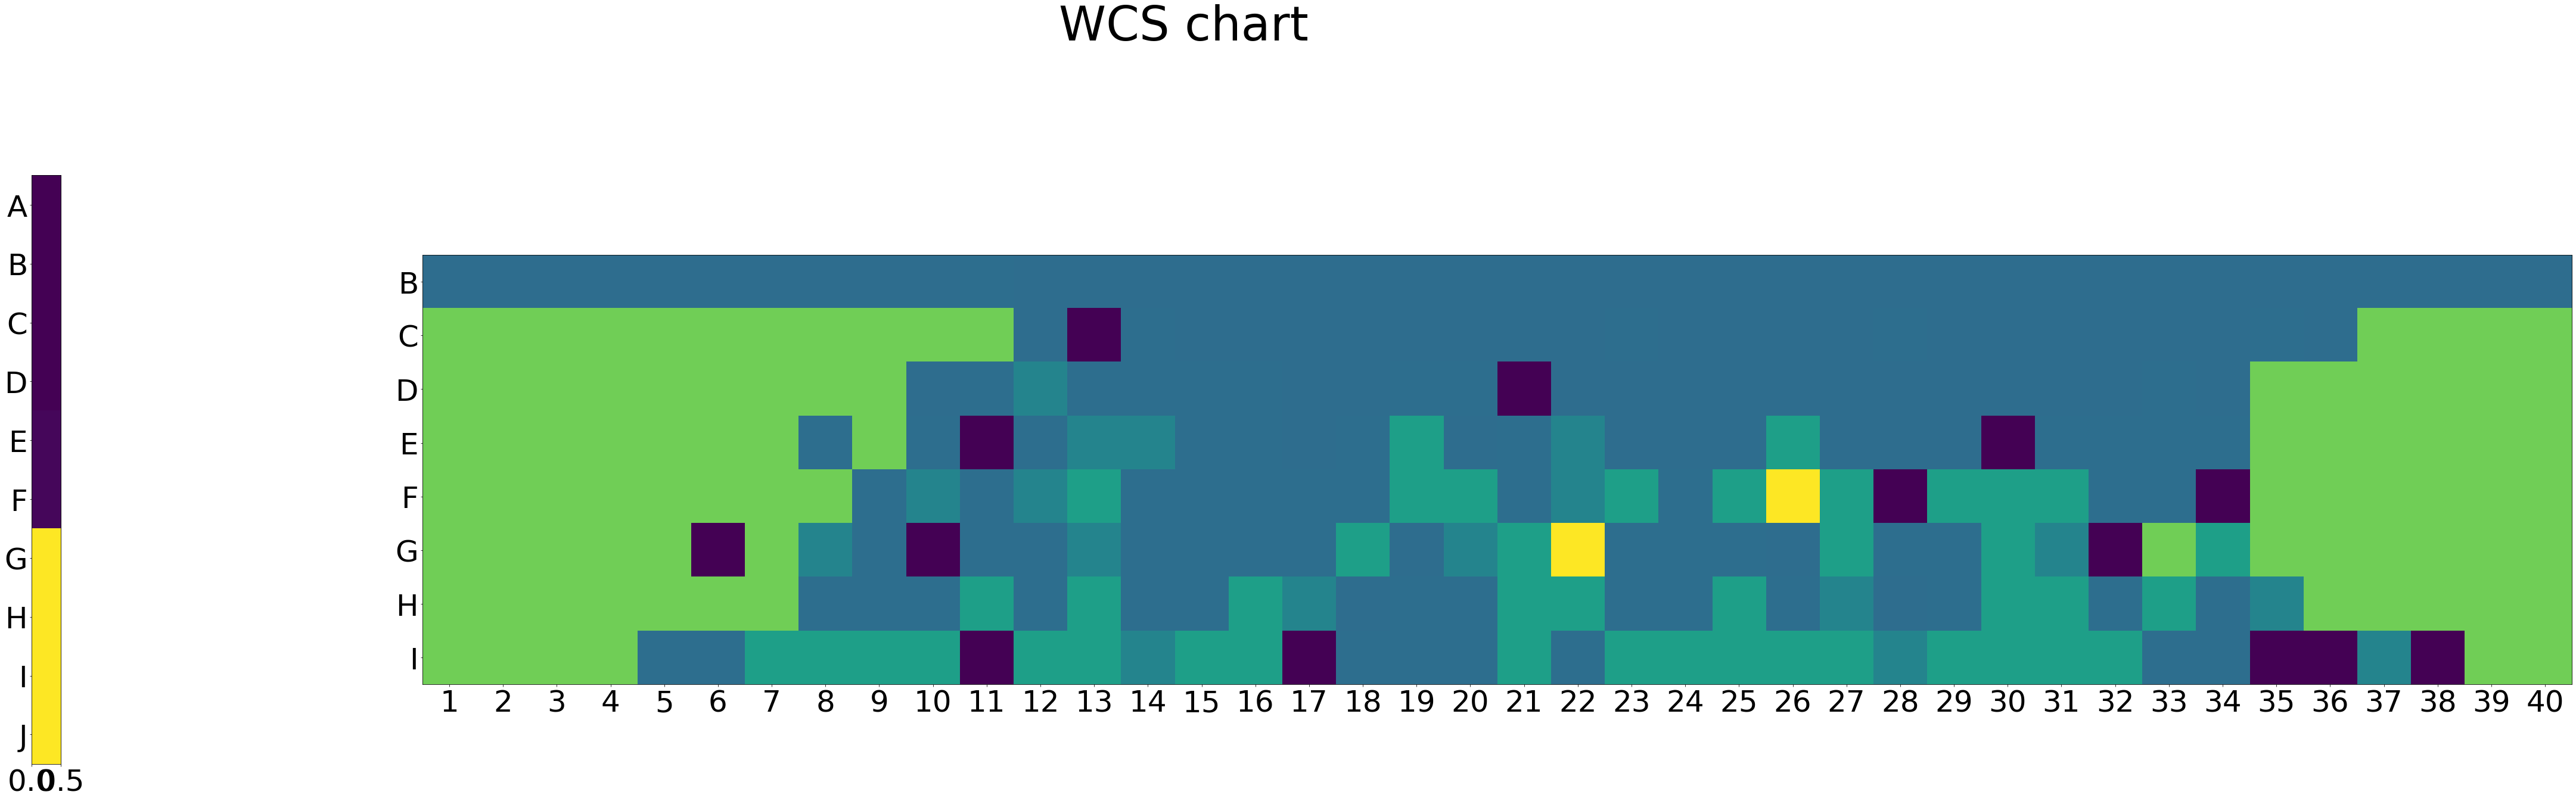

In [222]:
plotValues(encoded_terms)

**Note**: `plotValues()` is a generic function for visualizing various kinds of information on the chart, suited to needs.

Now you are in a position to start exploring this data set - enjoy!

In this cell we define some functions, mainly our Leave-one-out-cross-validation training functions.

In [164]:

def is_empty(any_structure):
    if any_structure:
        return False
    else:
        return True

### Exemplar Model

def LOOCV_Exemplar(F, terms_inds):
    loo = LeaveOneOut()
    loo.get_n_splits(F)
    accuracy = 0
    prediction_values = []

    for train_index, test_index in loo.split(F):

        # Get training and testing data points

        F_train, F_test = np.asarray(F)[train_index], np.asarray(F)[test_index]
        y_train, y_test = labels[train_index], labels[test_index]

        # This is the test coordinate (F_test[0]) and the target color term (y_test)
        # print (F_test[0], y_test)

        prediction = ''

        dist_dict = {}
        sim_dict = {}

        for term in terms_inds.keys():
            # Calculate the distance from the test coordinate to every single exemplar of each color category
            dist_dict[term] = np.array([spatial.distance.euclidean(coord, F_test[0]) for coord in terms_inds[term] if np.all(coord != F_test[0])])

            # Calculate the average simlarity between the test coordinate and each color category  
            sim_dict[term] = np.sum(np.exp(-(dist_dict[term])**2)) / len(dist_dict[term])

        # print(sim_dict)

        # Choose the color category with the highest similarity 
        prediction = max(sim_dict, key=sim_dict.get)

        # print (prediction)

        if prediction == y_test:
            accuracy += 1 
            
        prediction_values.append(prediction)
    
    accuracy = accuracy / 330
    
    return accuracy, prediction_values

def LOOCV_Prototype(F, terms_inds):
    
    loo = LeaveOneOut()
    loo.get_n_splits(F)
    accuracy = 0
    prediction_values = []

    for train_index, test_index in loo.split(F):

        # Get training and testing data points

        F_train, F_test = np.asarray(F)[train_index], np.asarray(F)[test_index]
        y_train, y_test = labels[train_index], labels[test_index]

        # This is the test coordinate (F_test[0]) and the target color term (y_test)
        # print (F_test[0], y_test)

        prediction = ''

        dist_dict = {}
        sim_dict = {}

        for term in terms_inds.keys():
            
            # Construct prototype
            #print (np.average([coord for coord in terms_inds[term]], axis = 0))
            prototype = np.average([coord for coord in terms_inds[term]])
            
            # Calculate the distance from the test coordinate to prototype of this color term, store it in our dictionary
            dist_dict[term] = spatial.distance.euclidean(prototype, F_test[0])
        
        
        # print(sim_dict)

        # Choose the color category with the highest similarity 
        prediction = min(dist_dict, key=dist_dict.get)

        # print (prediction)

        if prediction == y_test:
            accuracy += 1 
            
        prediction_values.append(prediction)
    
    accuracy = accuracy / 330
    
    return accuracy, prediction_values


=====================STARTING LANGUAGE:  40 ================================
Color categories: ['Y', 'U', 'C', 'PI', 'PO', 'P', 'O']
Exemplar accuracy for language 40 : 0.6727272727272727
Prototype accuracy for language 40 : 0.31212121212121213
=====================STARTING LANGUAGE:  41 ================================
Color categories: ['SU', 'SI', 'OS', 'TO', 'SA', 'SE']
Exemplar accuracy for language 41 : 0.6515151515151515
Prototype accuracy for language 41 : 0.3484848484848485
=====================STARTING LANGUAGE:  42 ================================
Color categories: ['D', 'K', 'W', 'S', 'N', 'B', 'T']
Exemplar accuracy for language 42 : 0.6545454545454545
Prototype accuracy for language 42 : 0.3303030303030303
=====================STARTING LANGUAGE:  43 ================================
Color categories: ['BA', 'AG', 'BF', 'GG', 'FD', 'GA', 'GE']
Exemplar accuracy for language 43 : 0.6090909090909091
Prototype accuracy for language 43 : 0.19696969696969696
====================

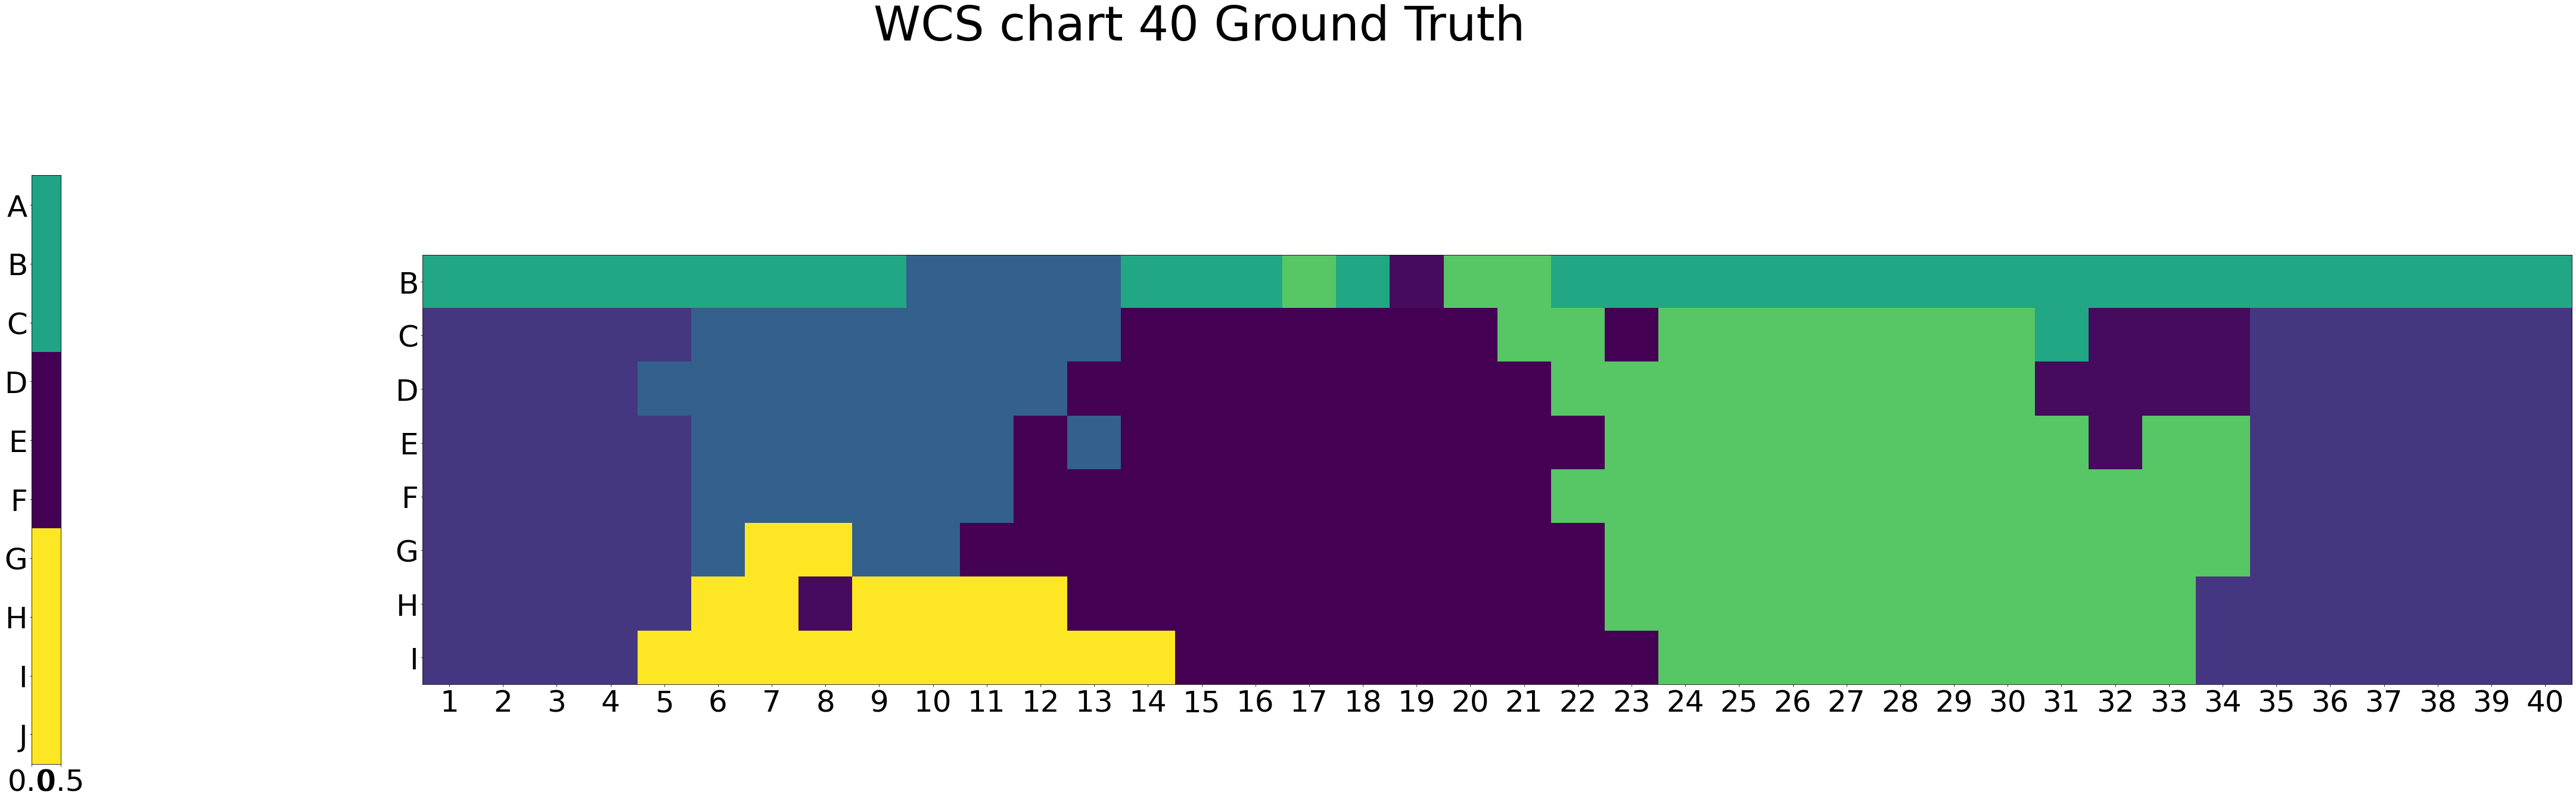

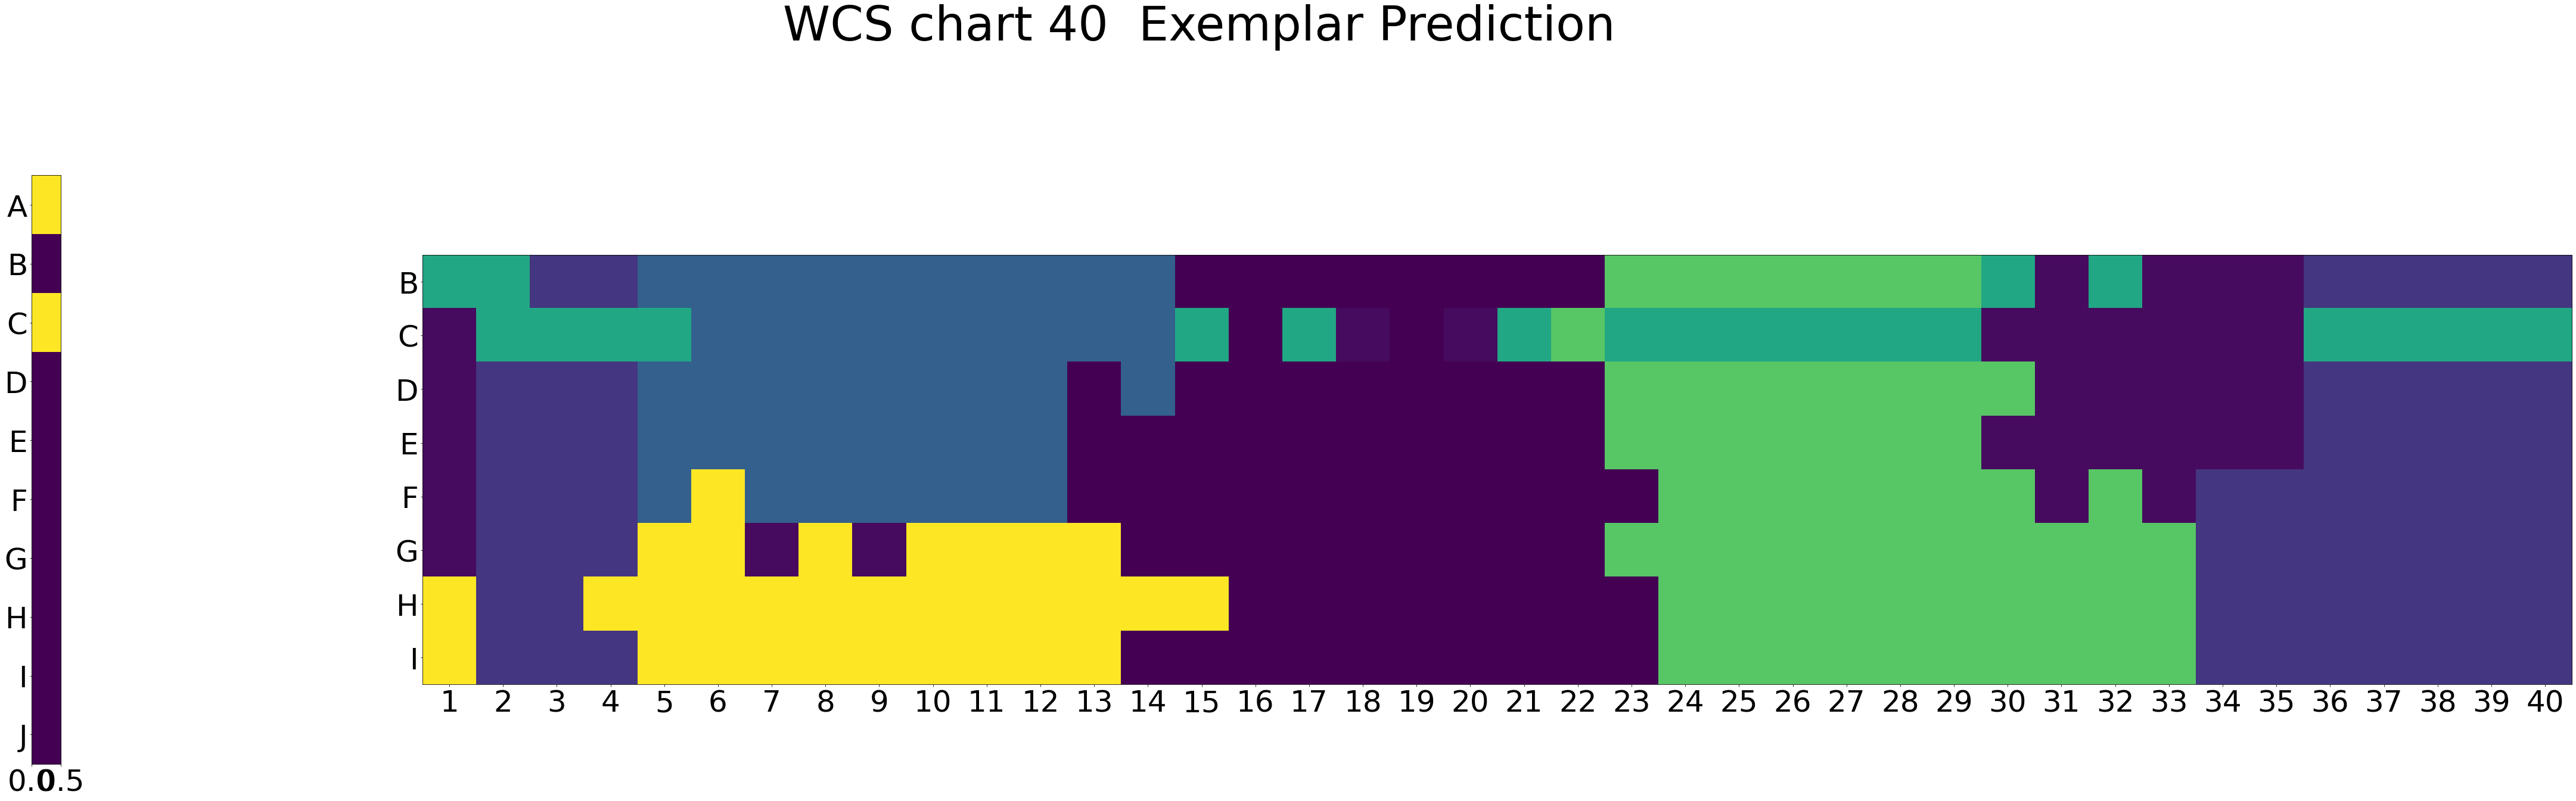

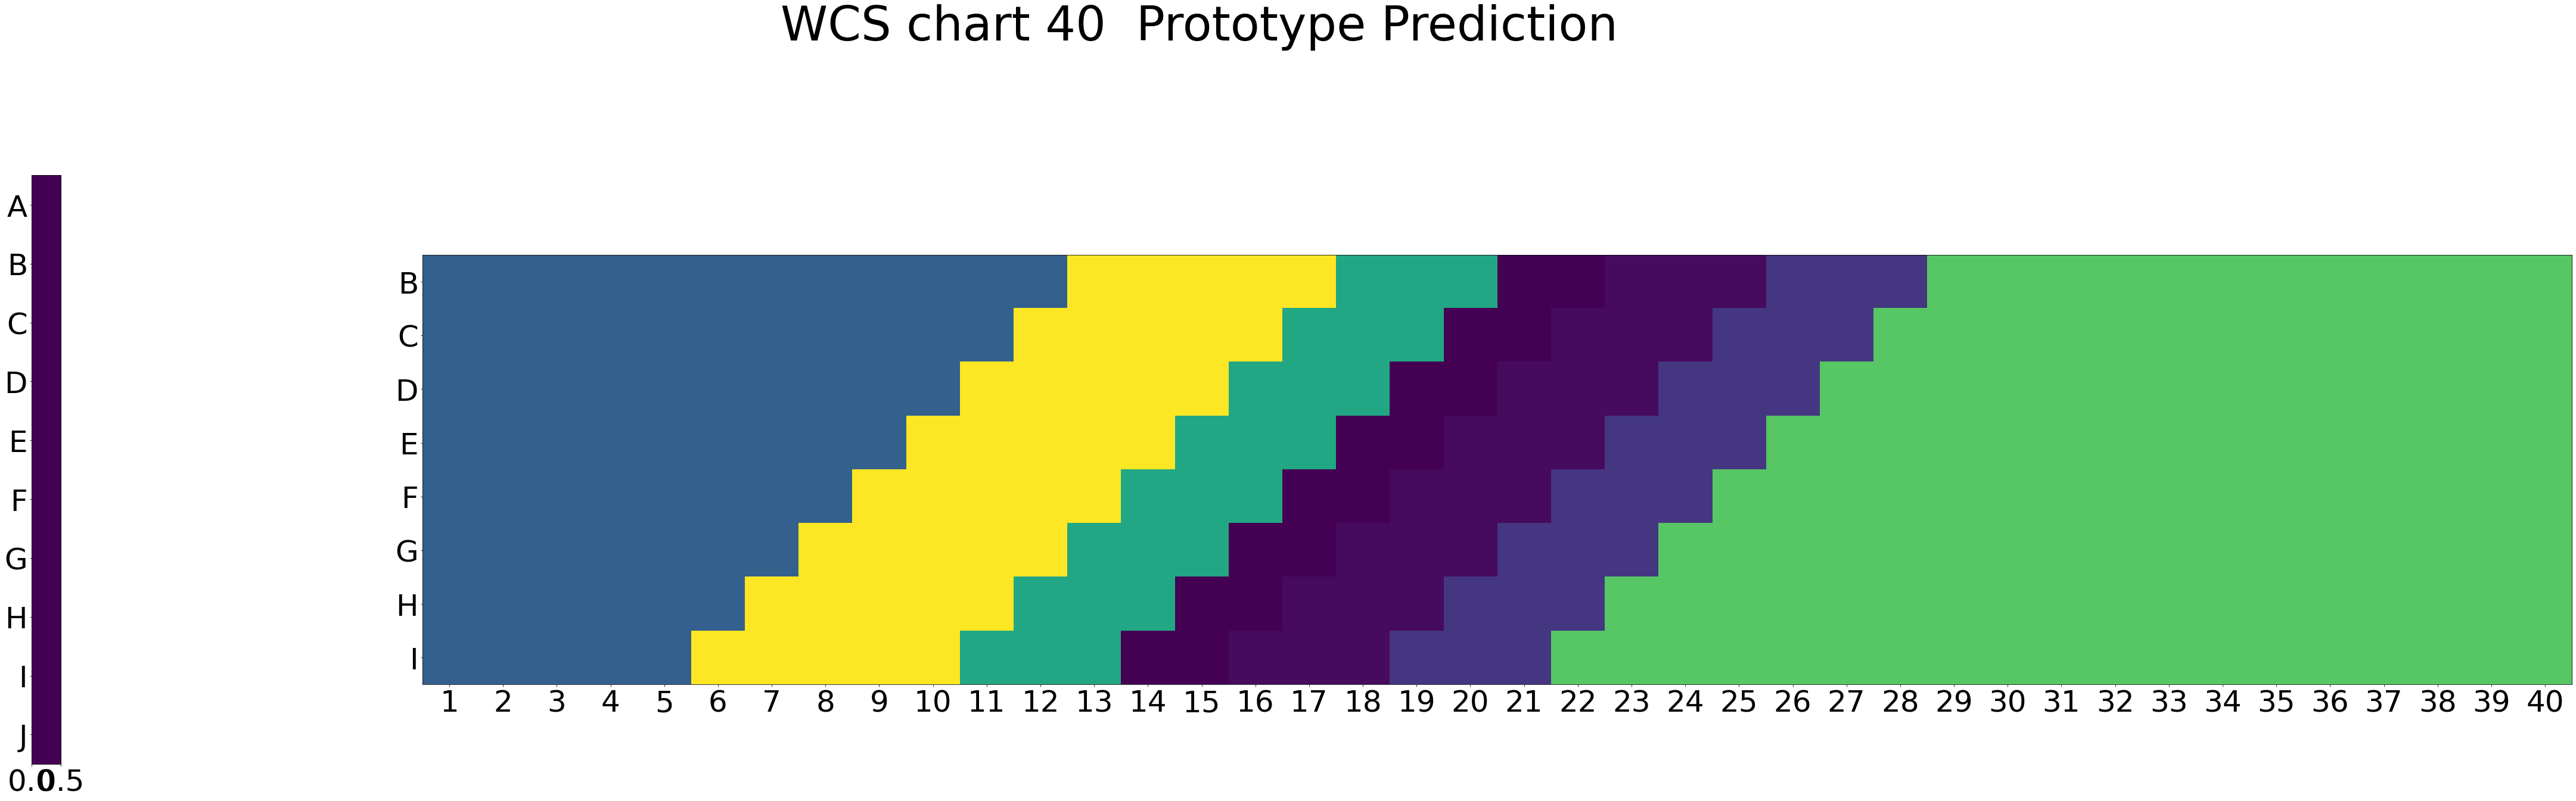

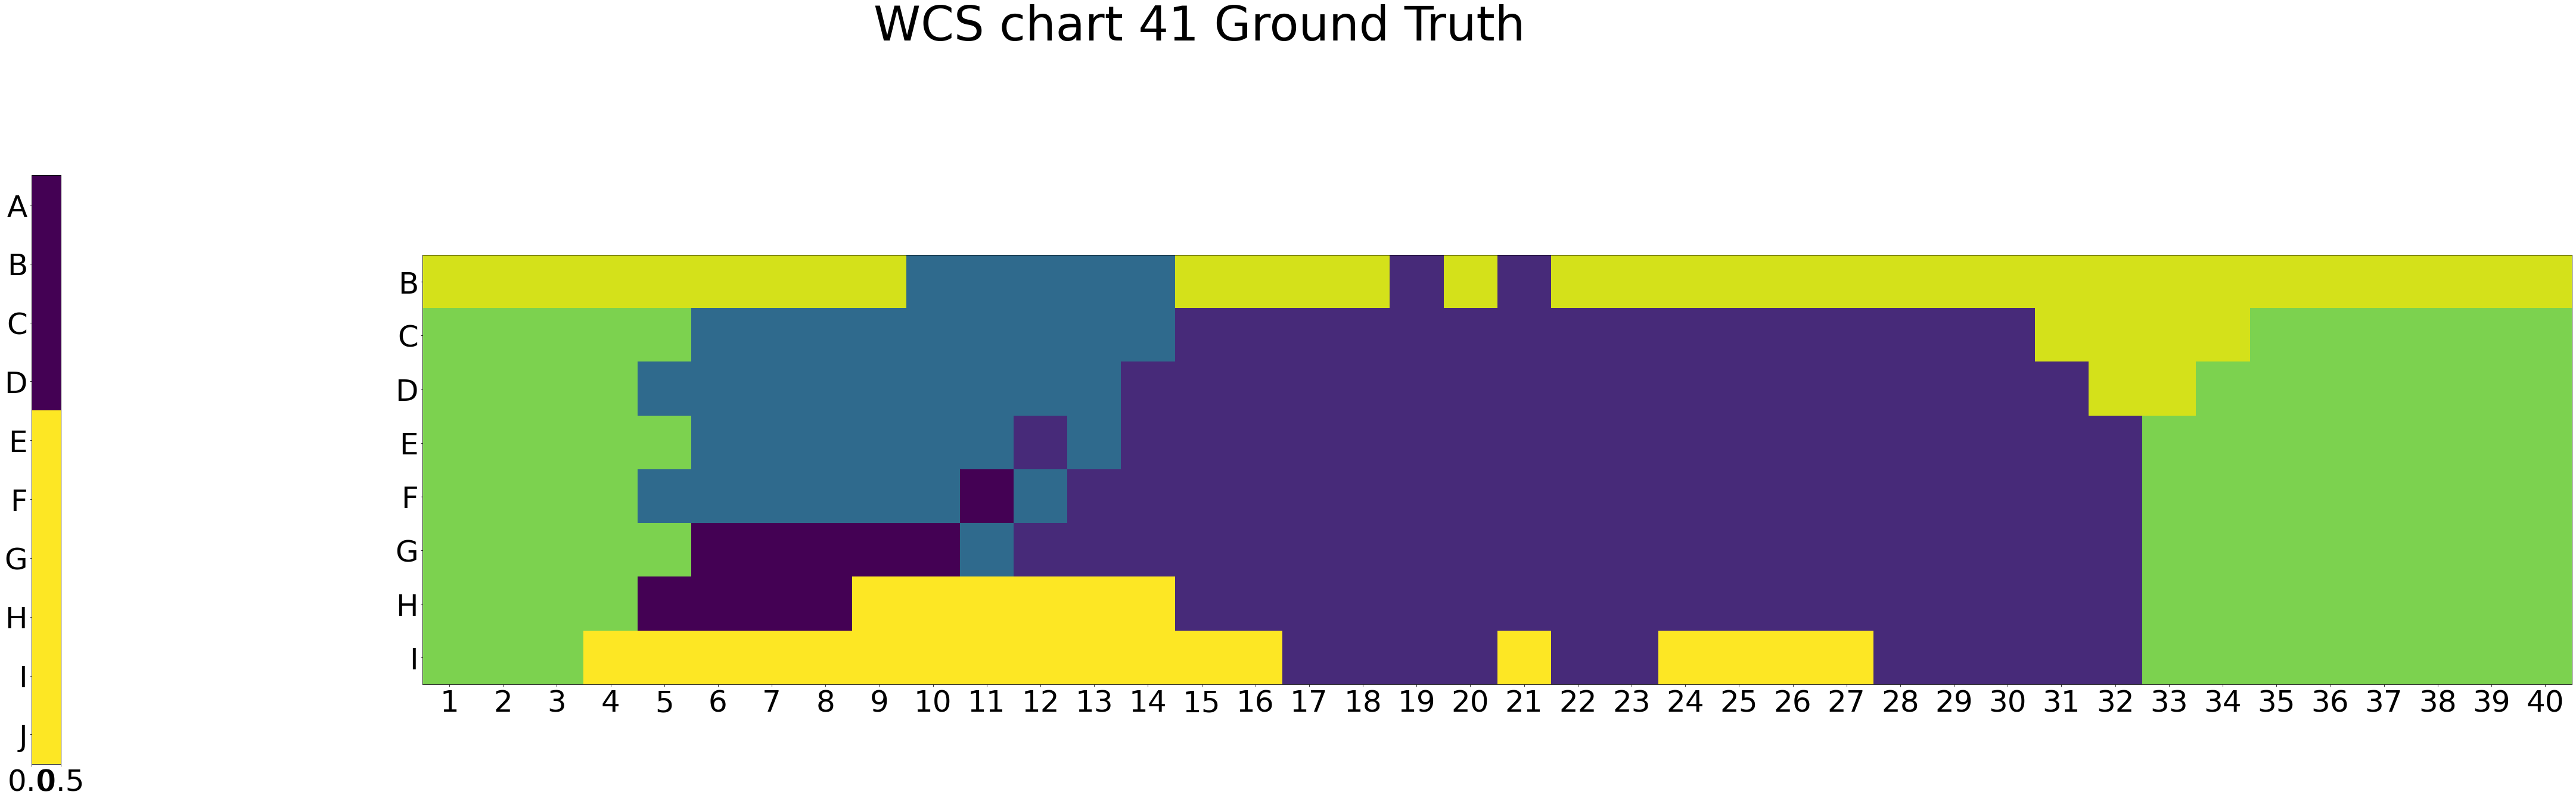

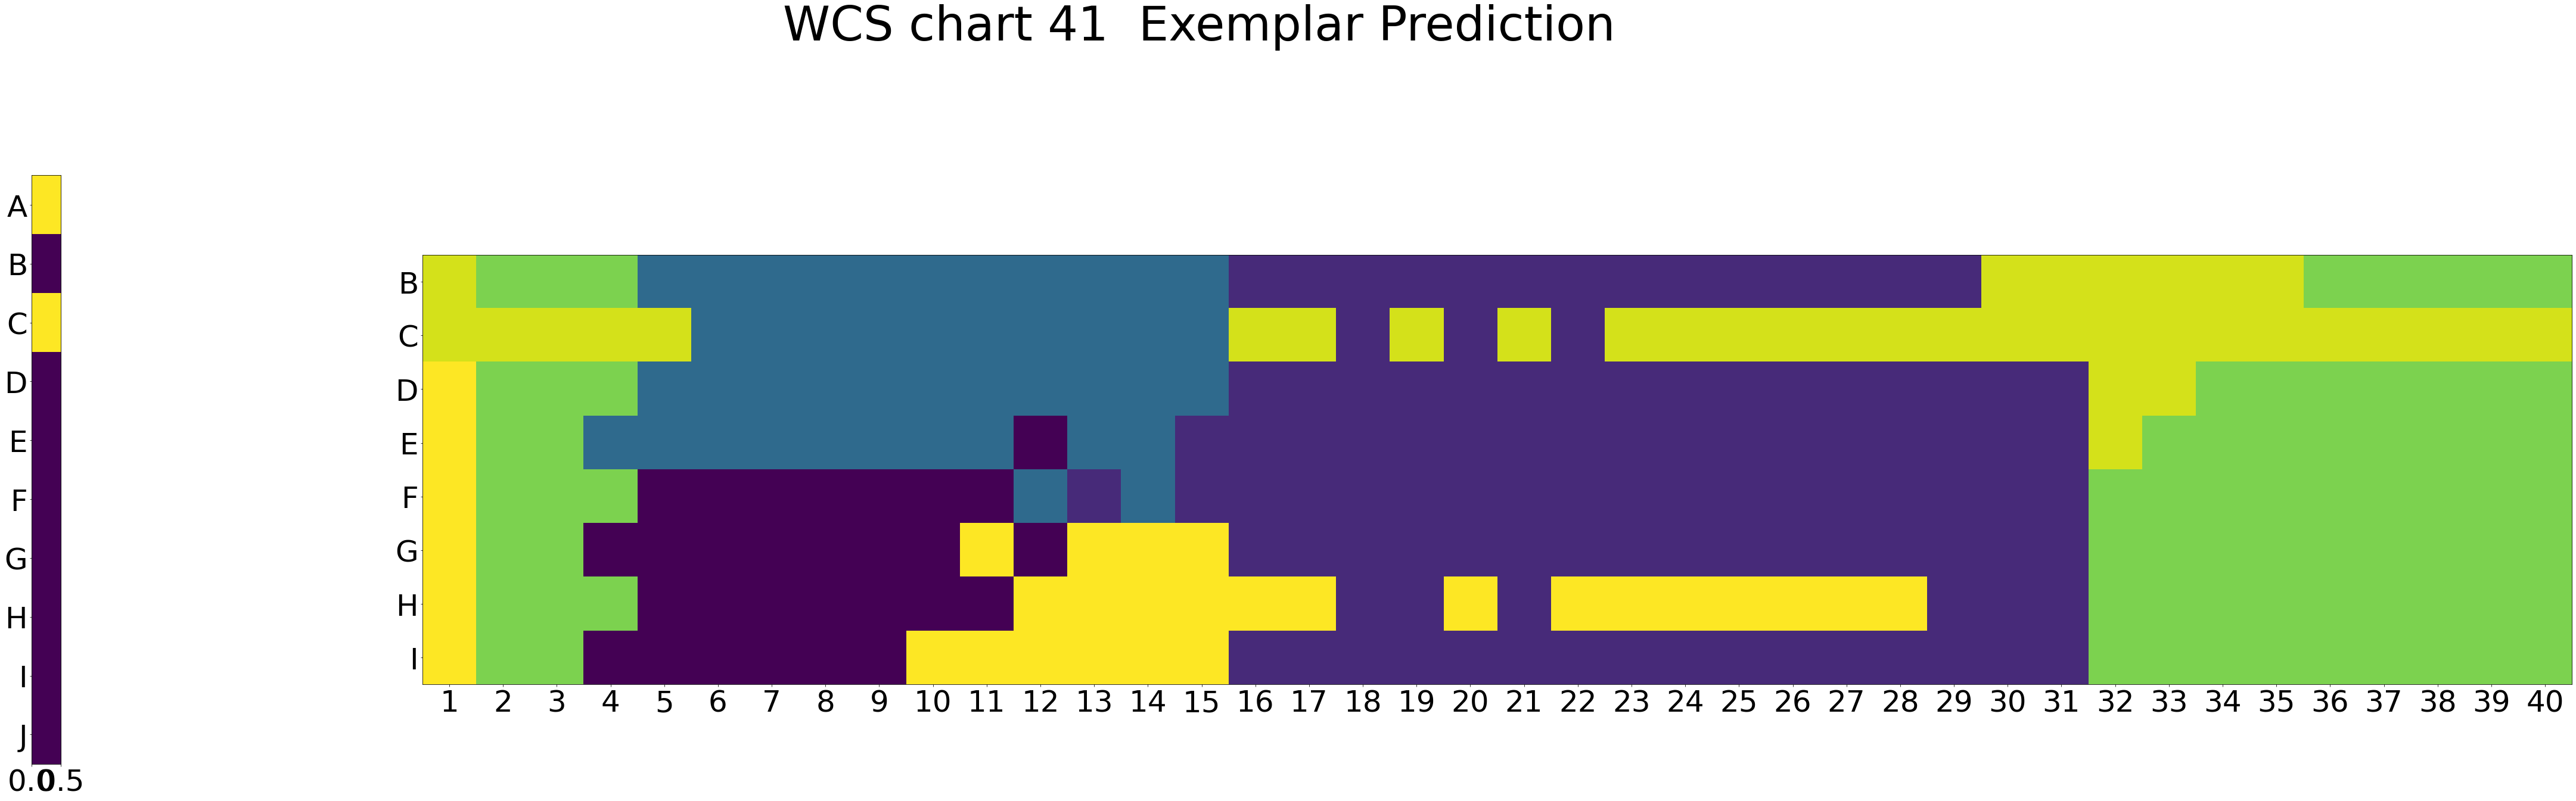

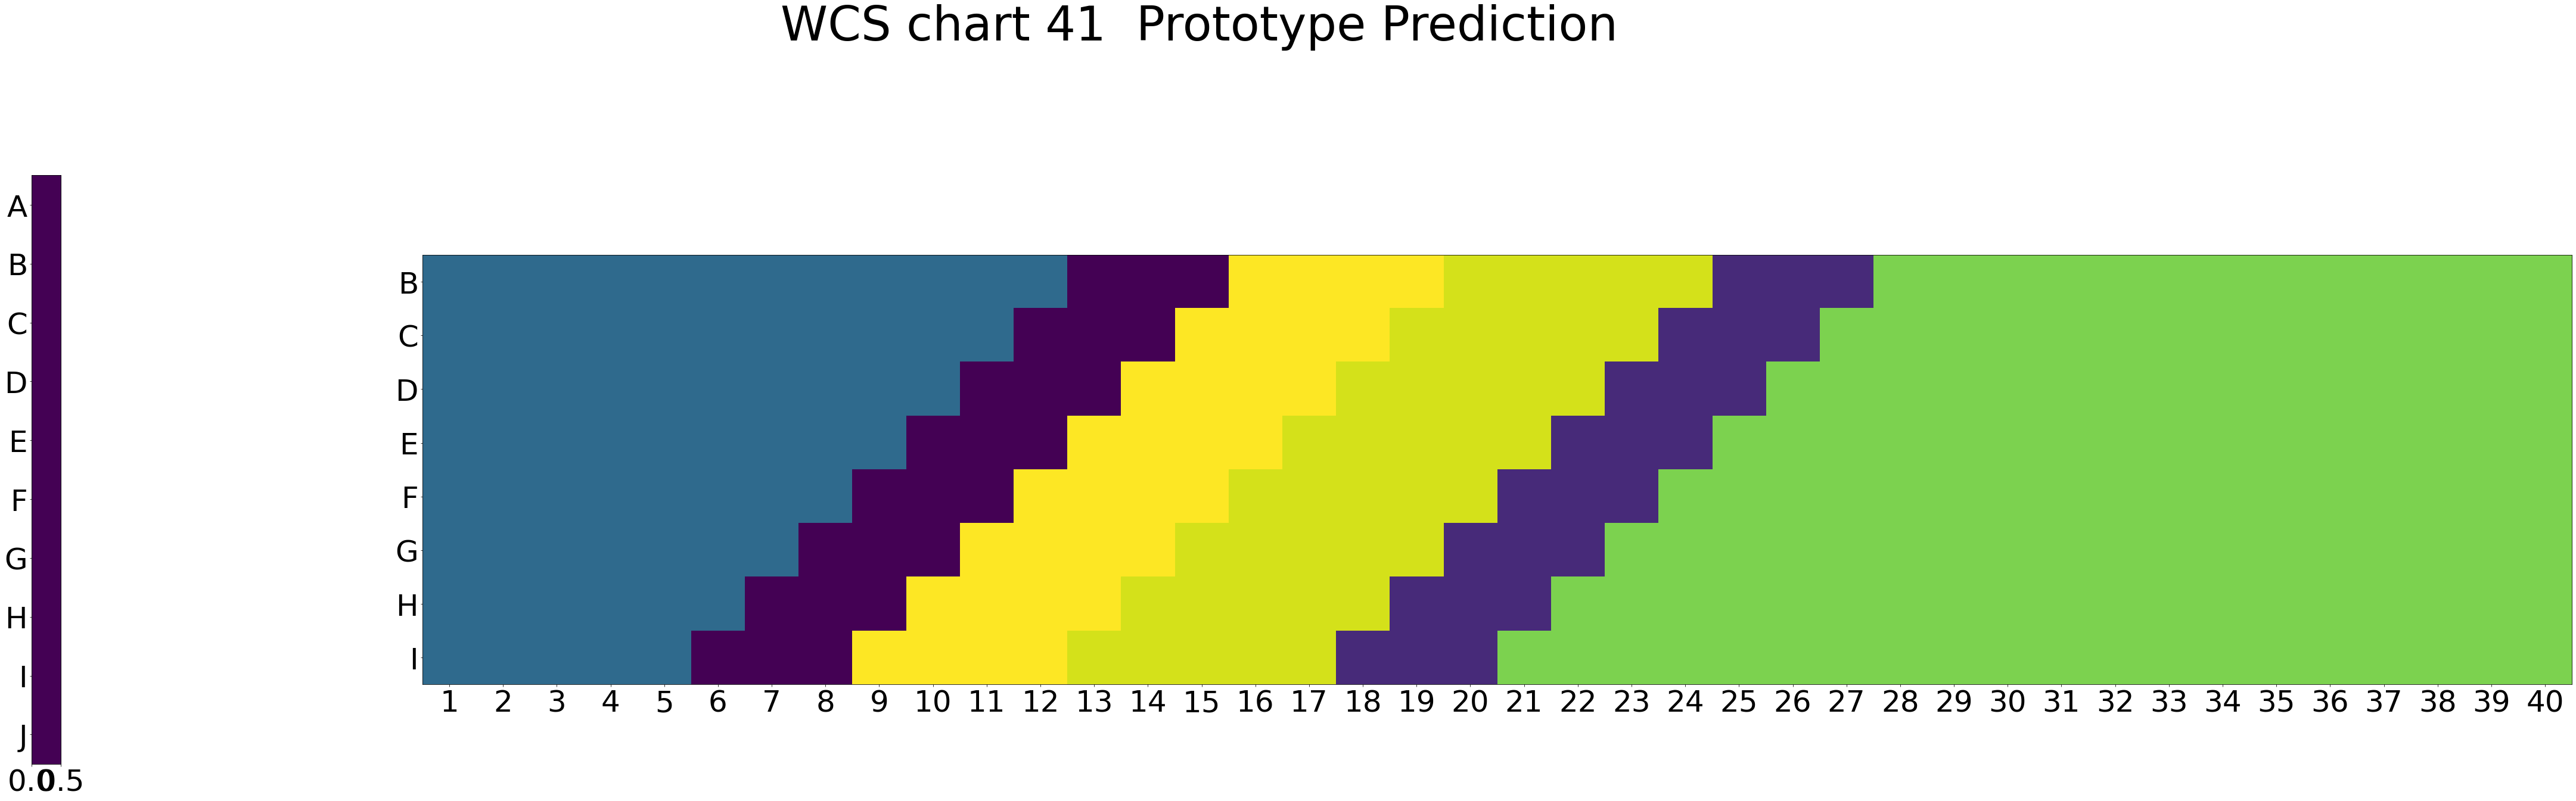

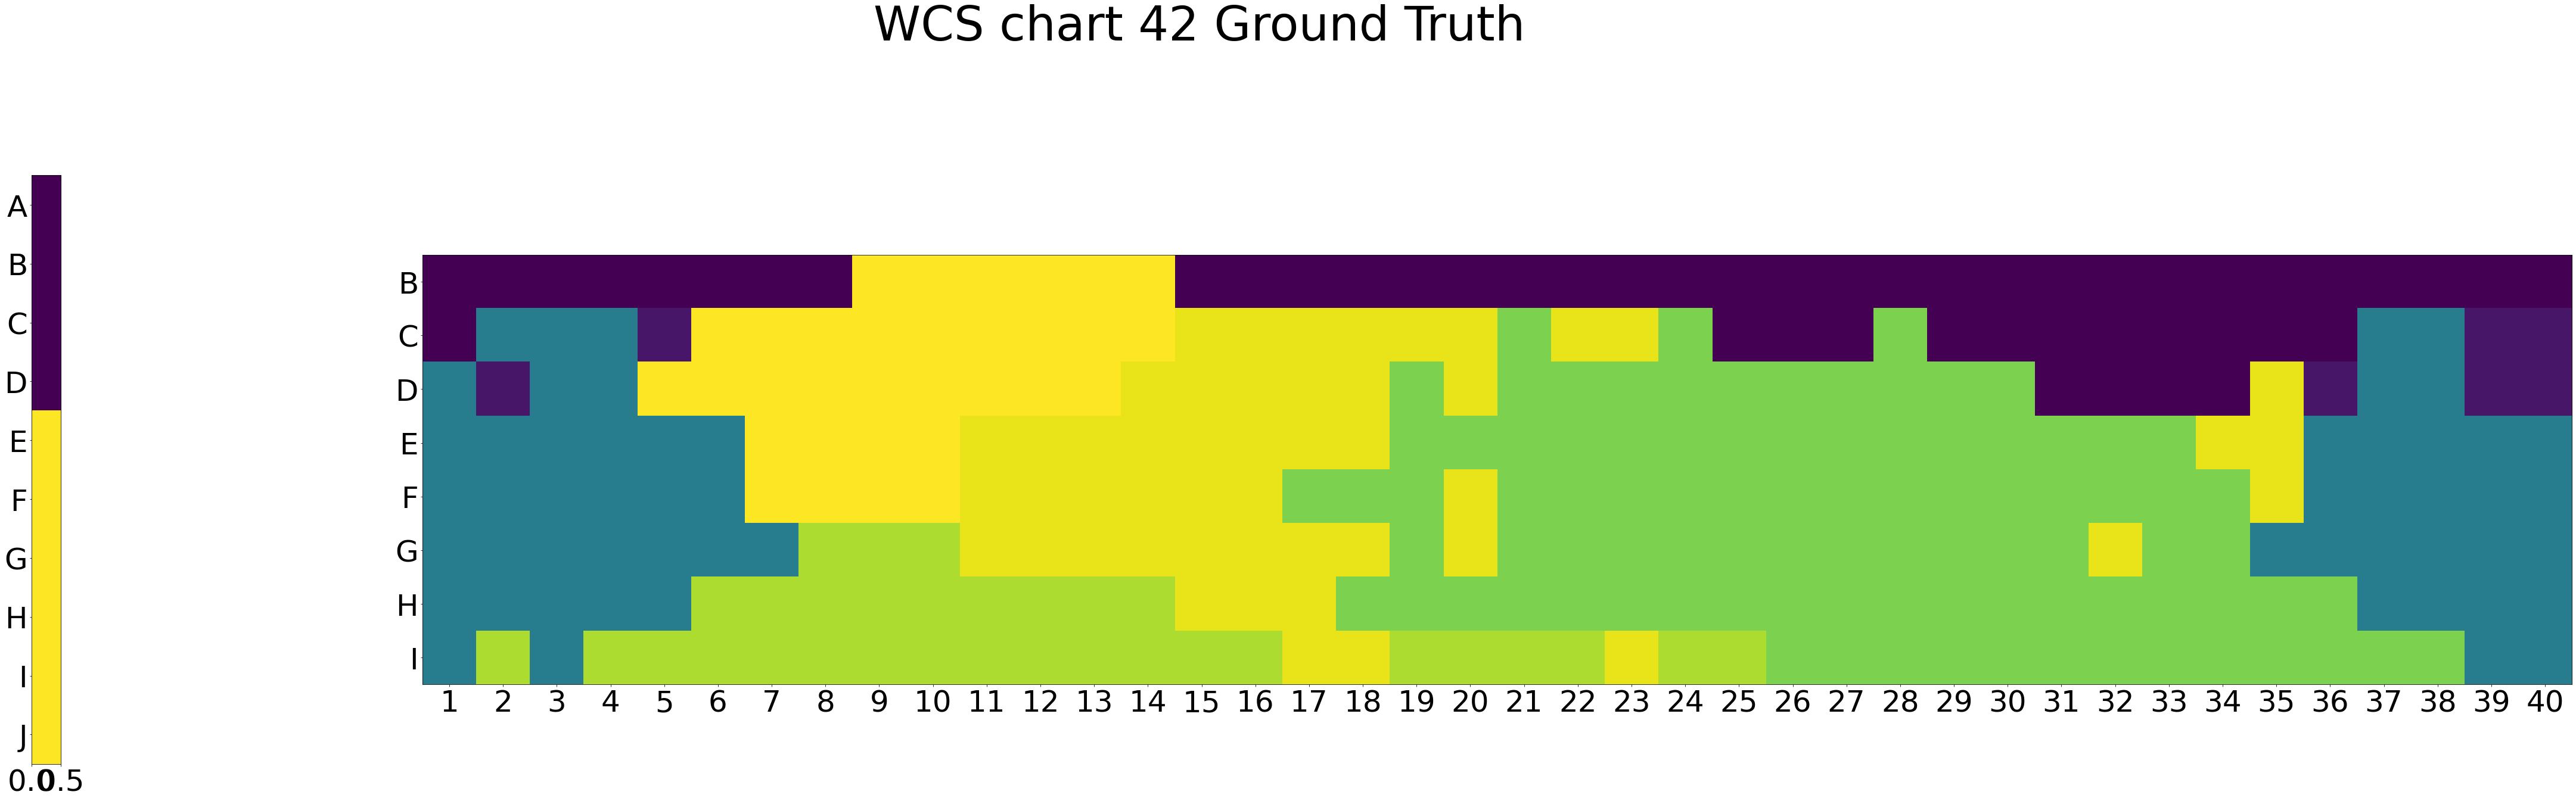

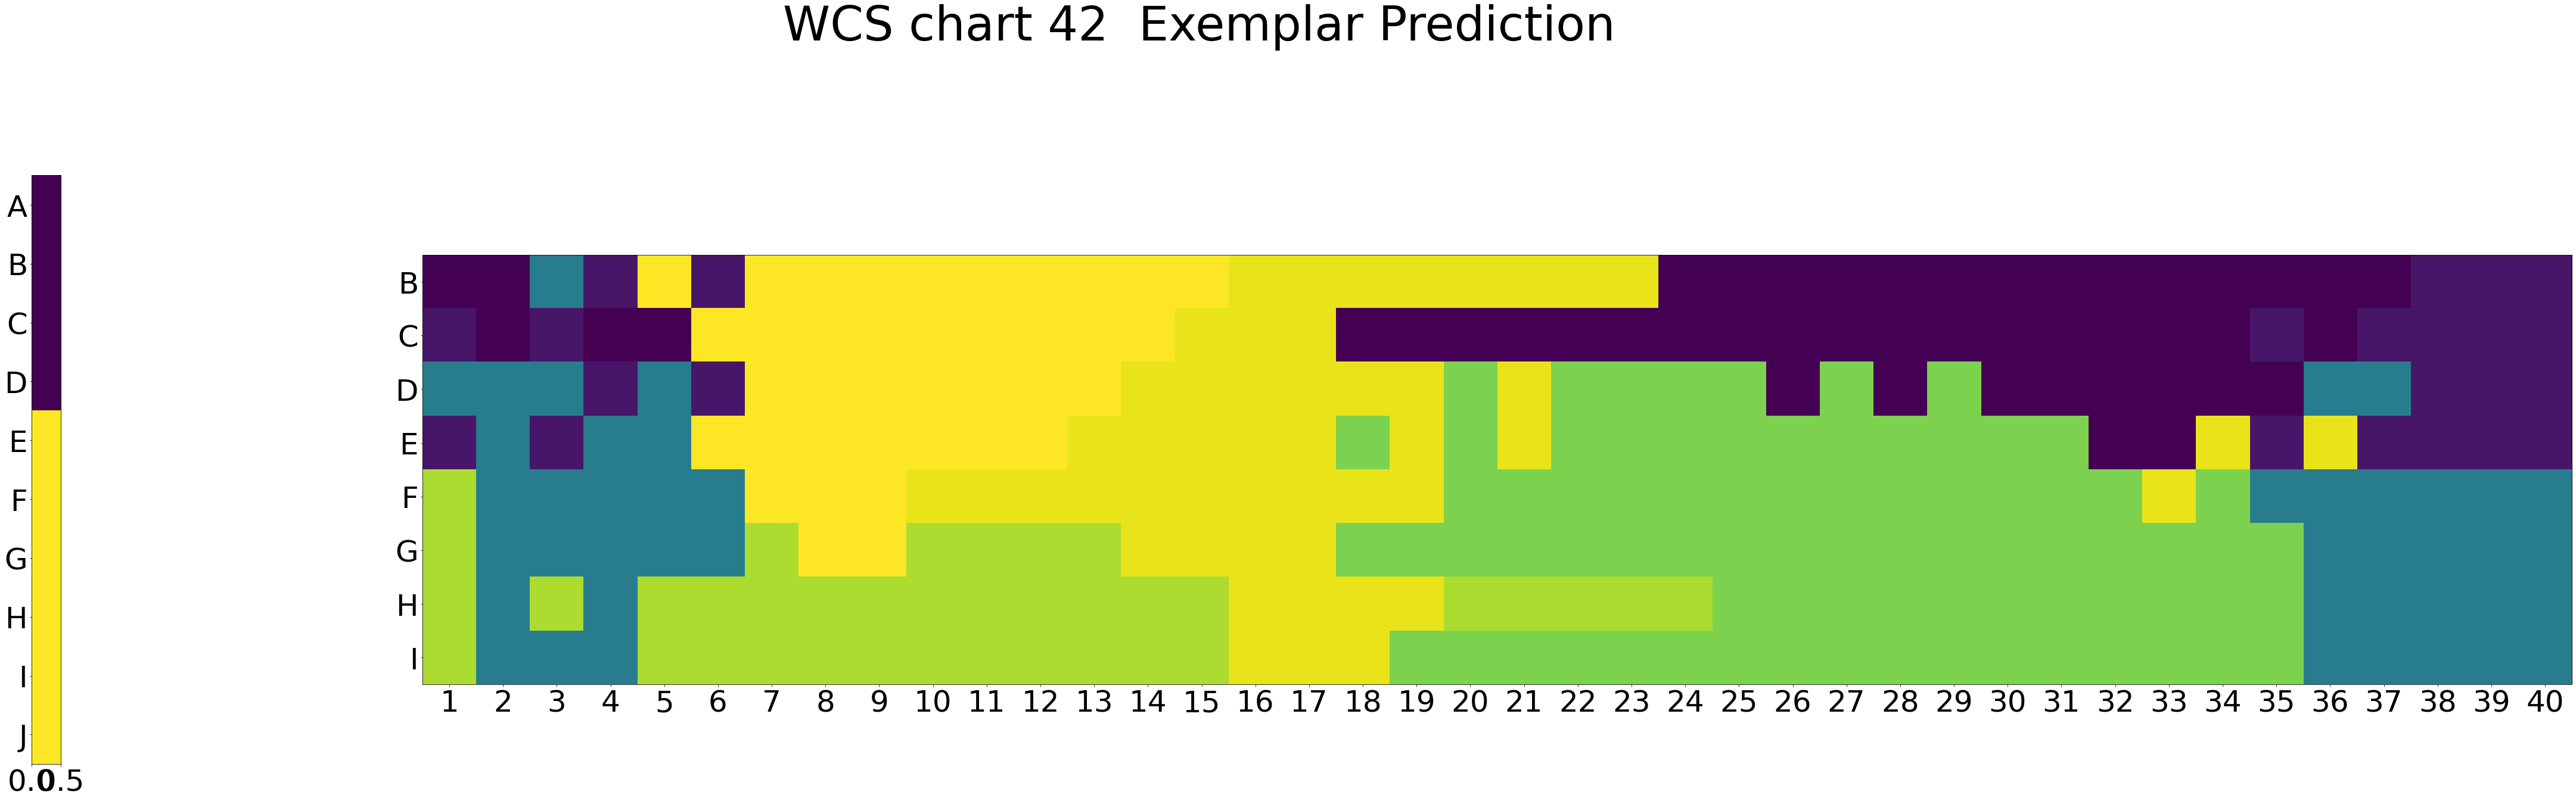

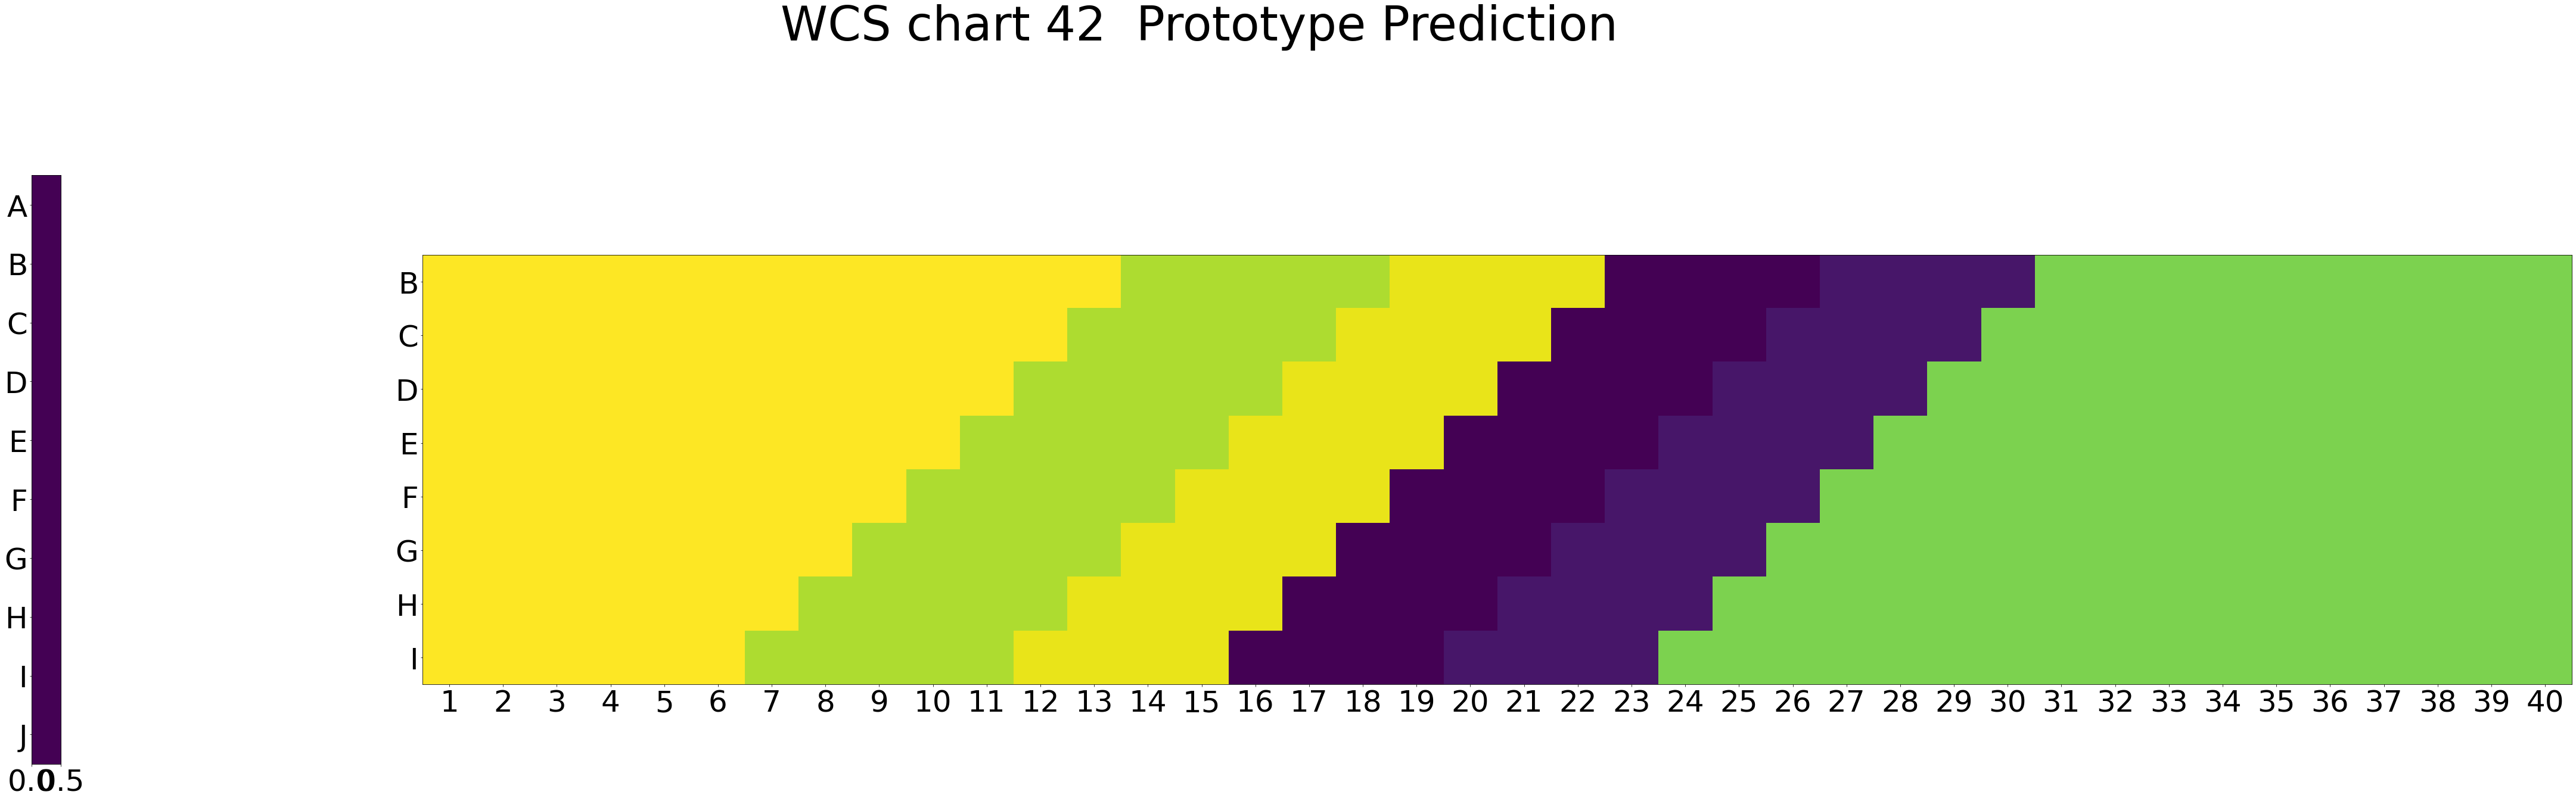

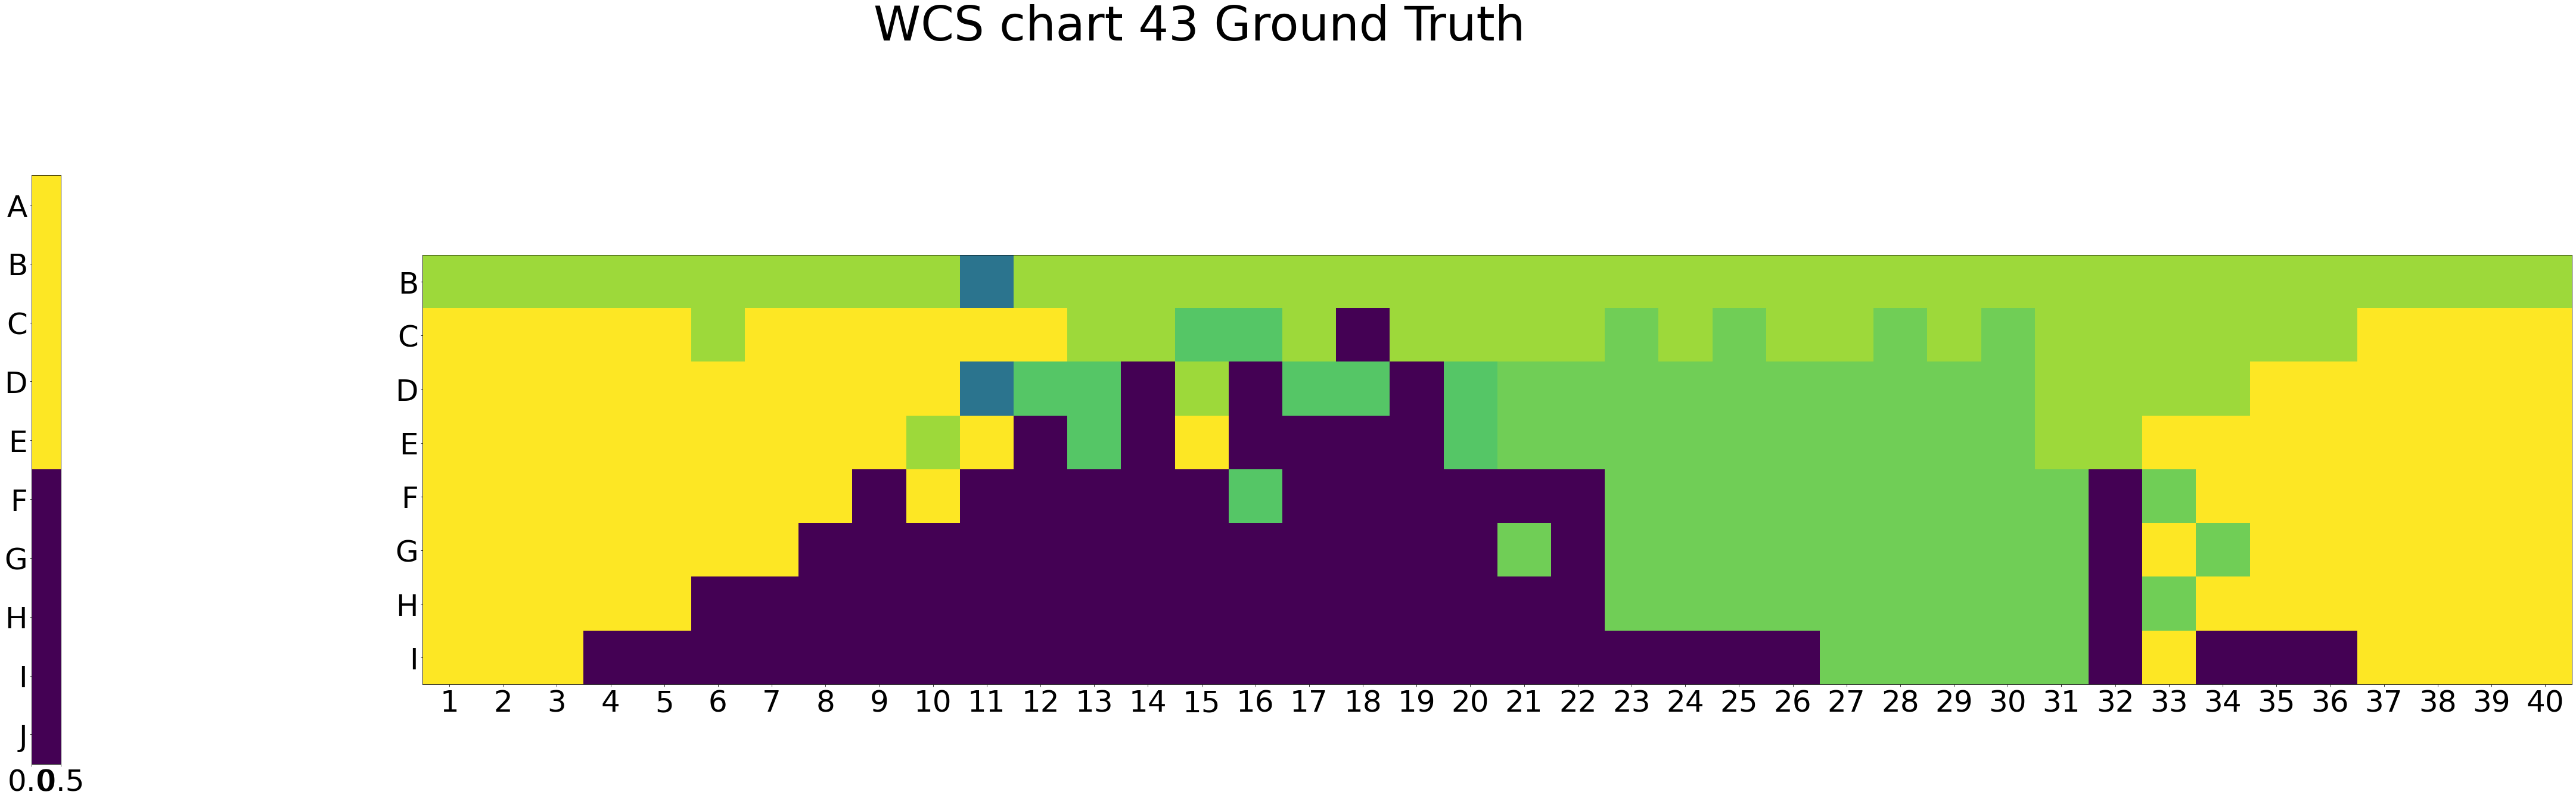

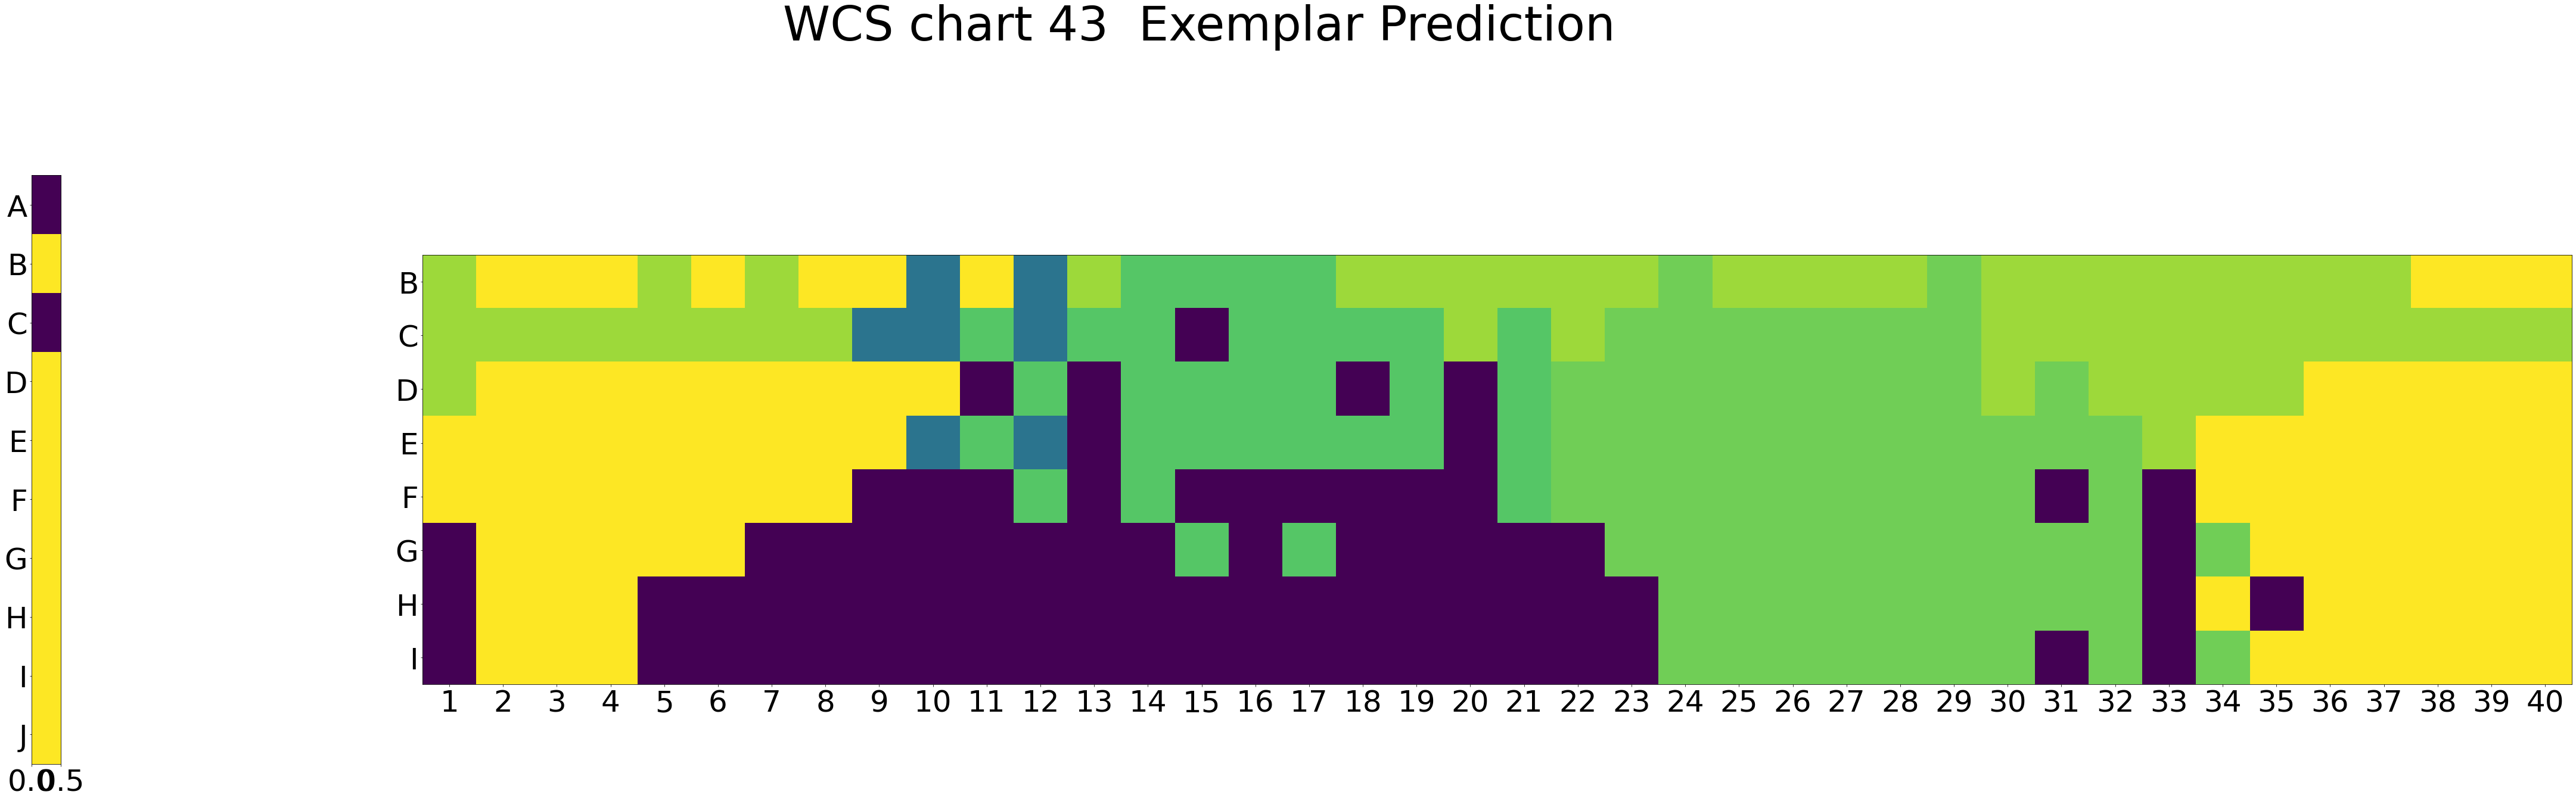

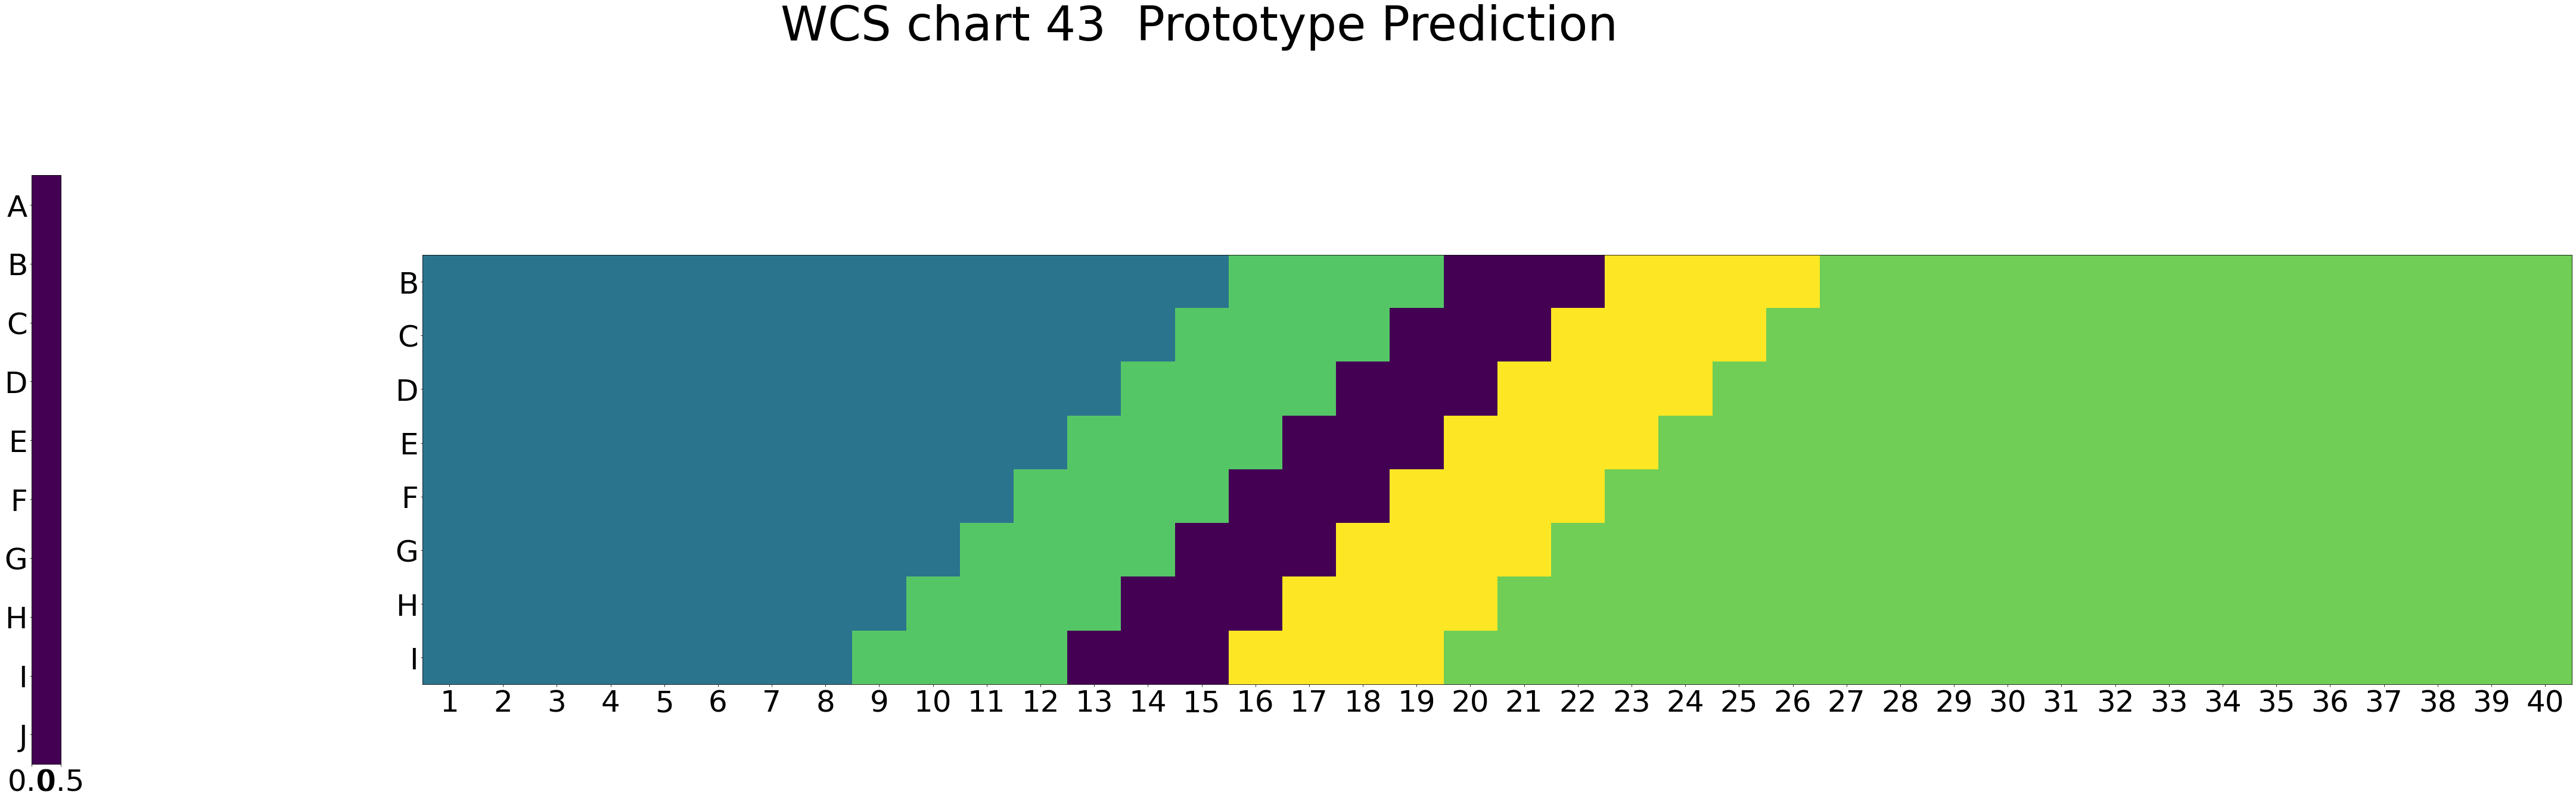

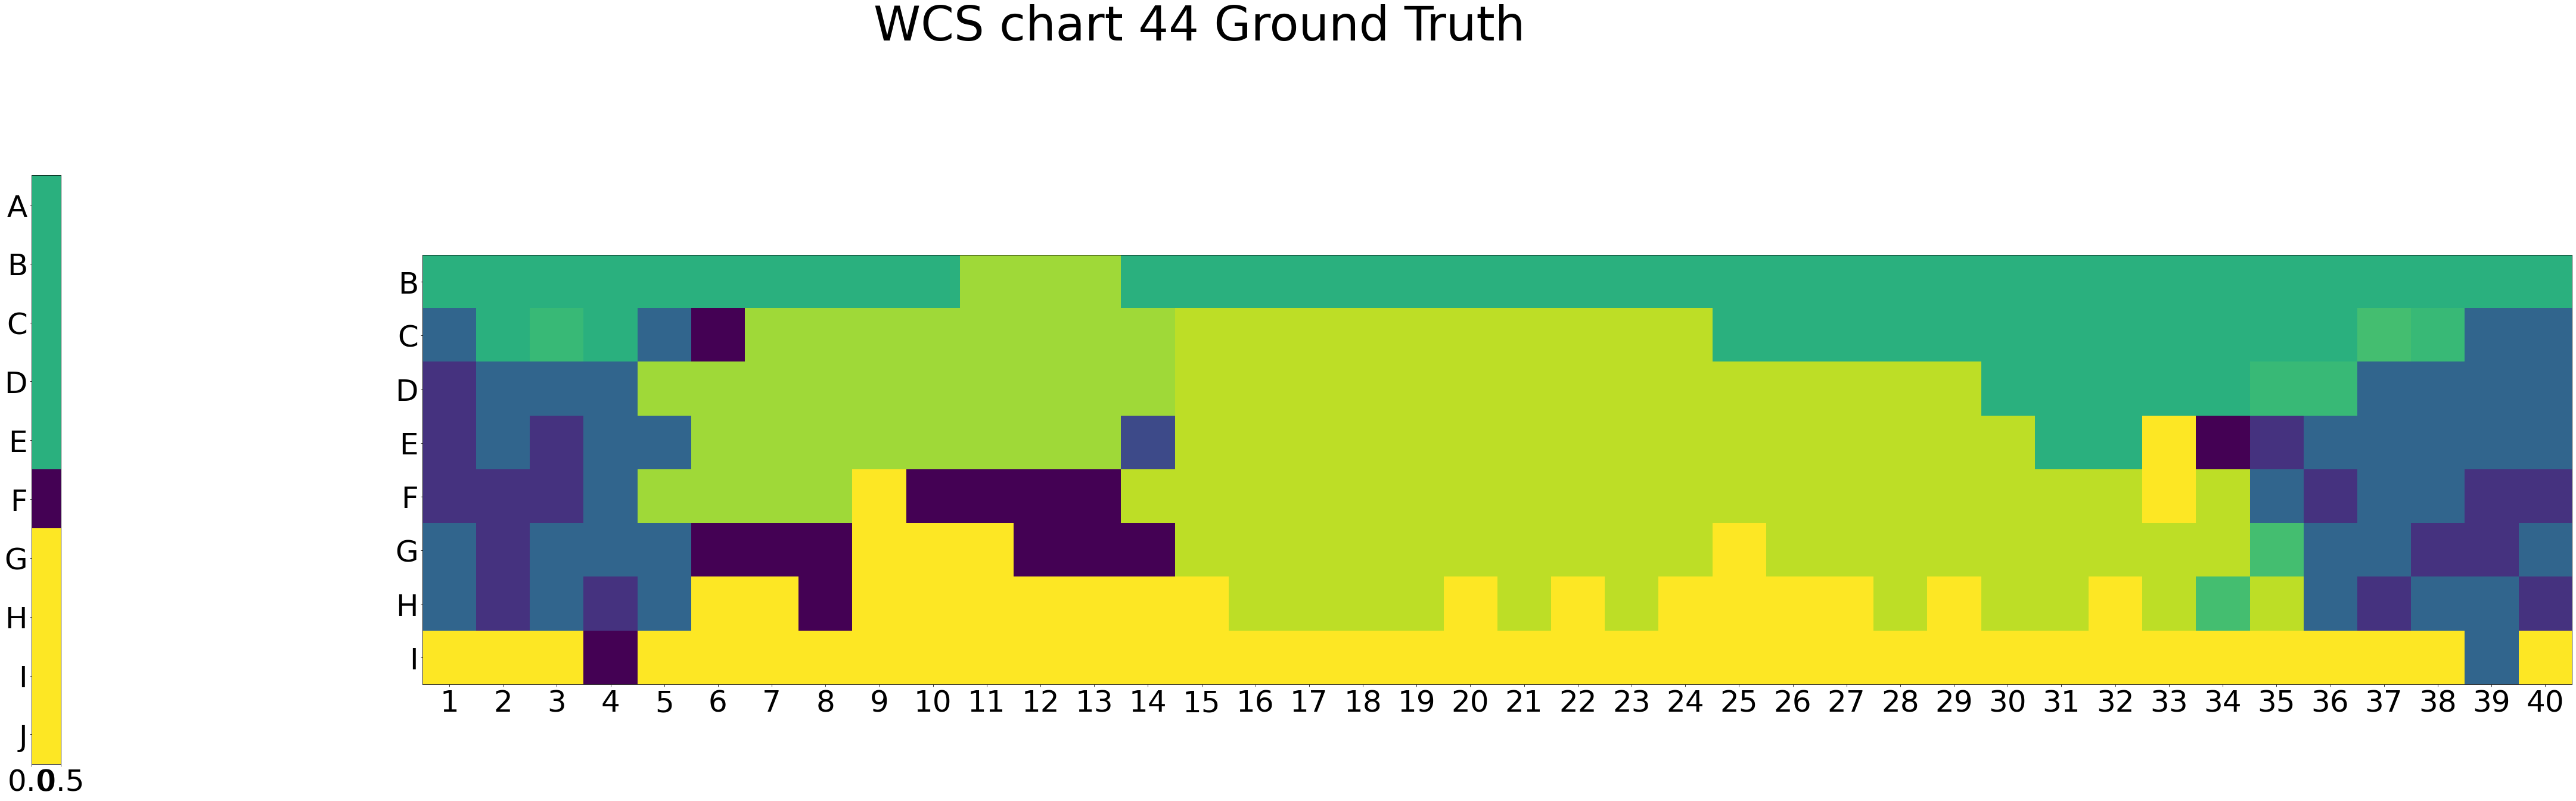

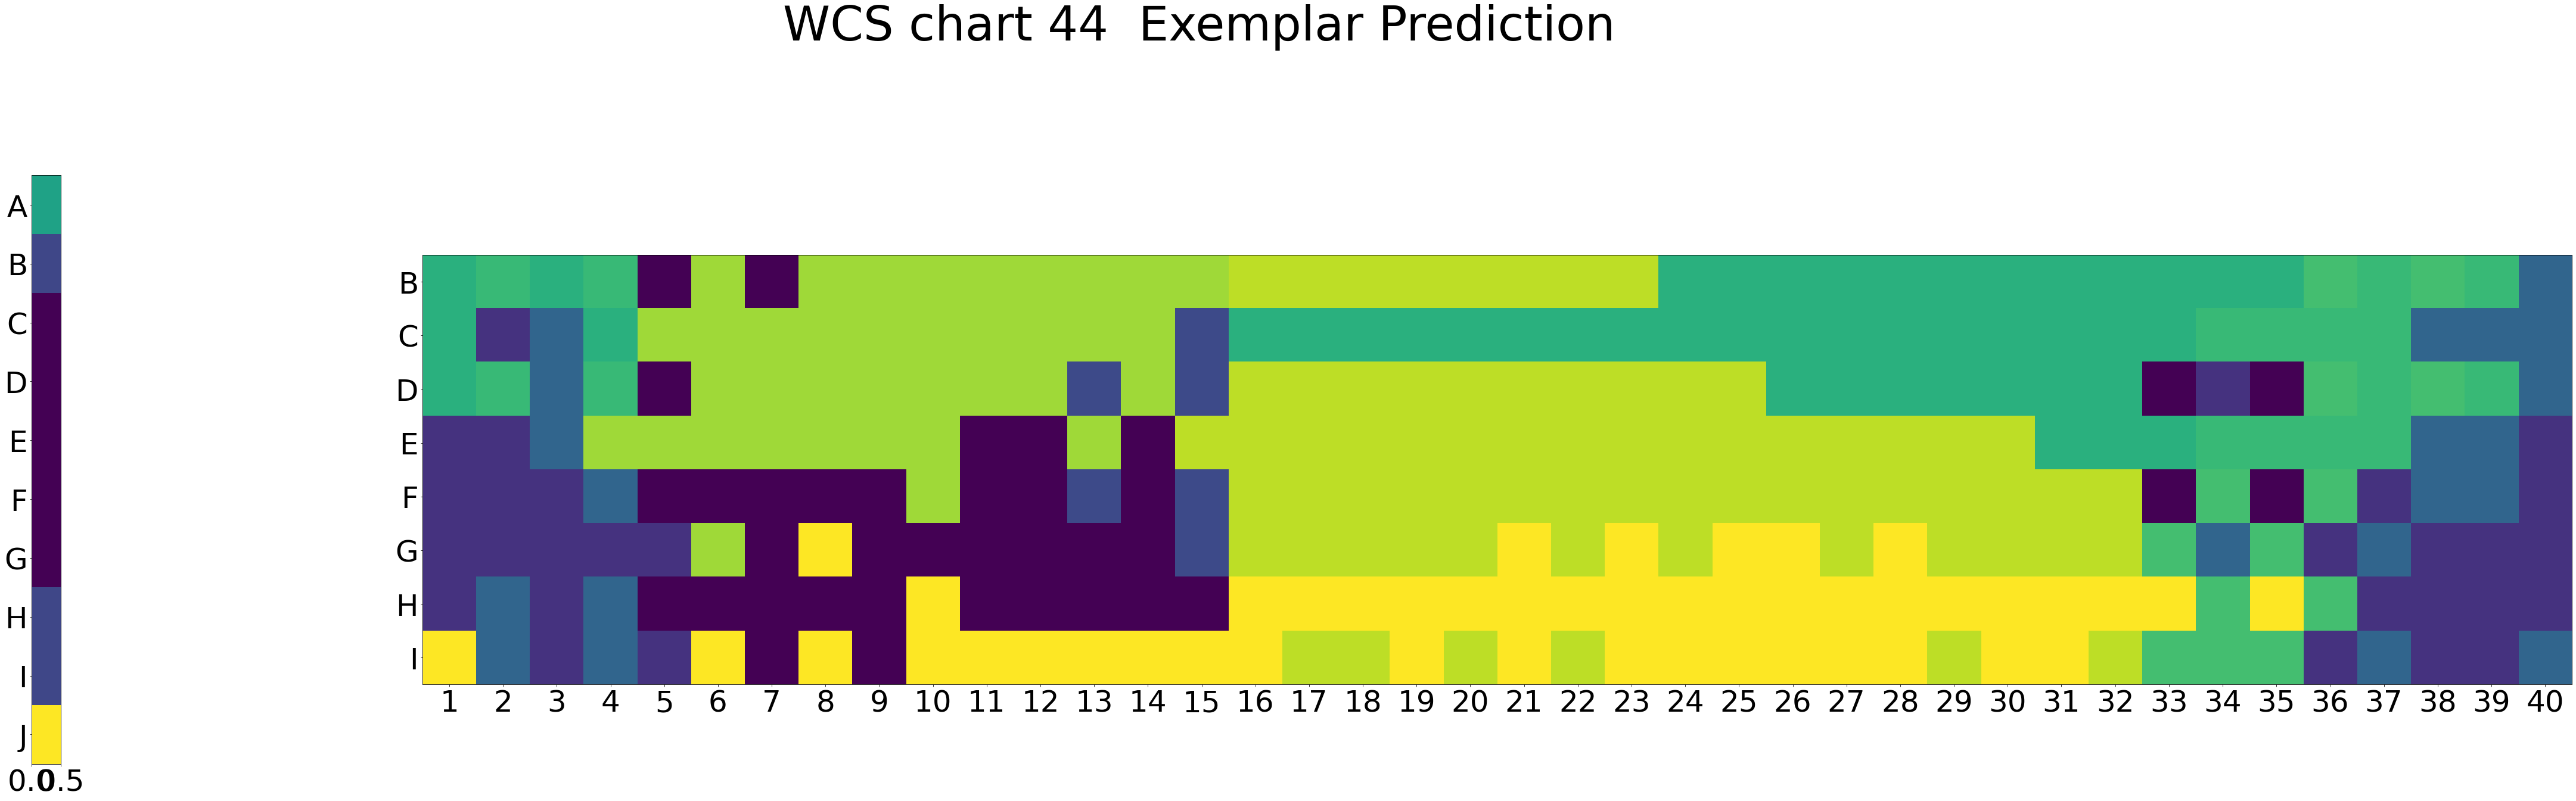

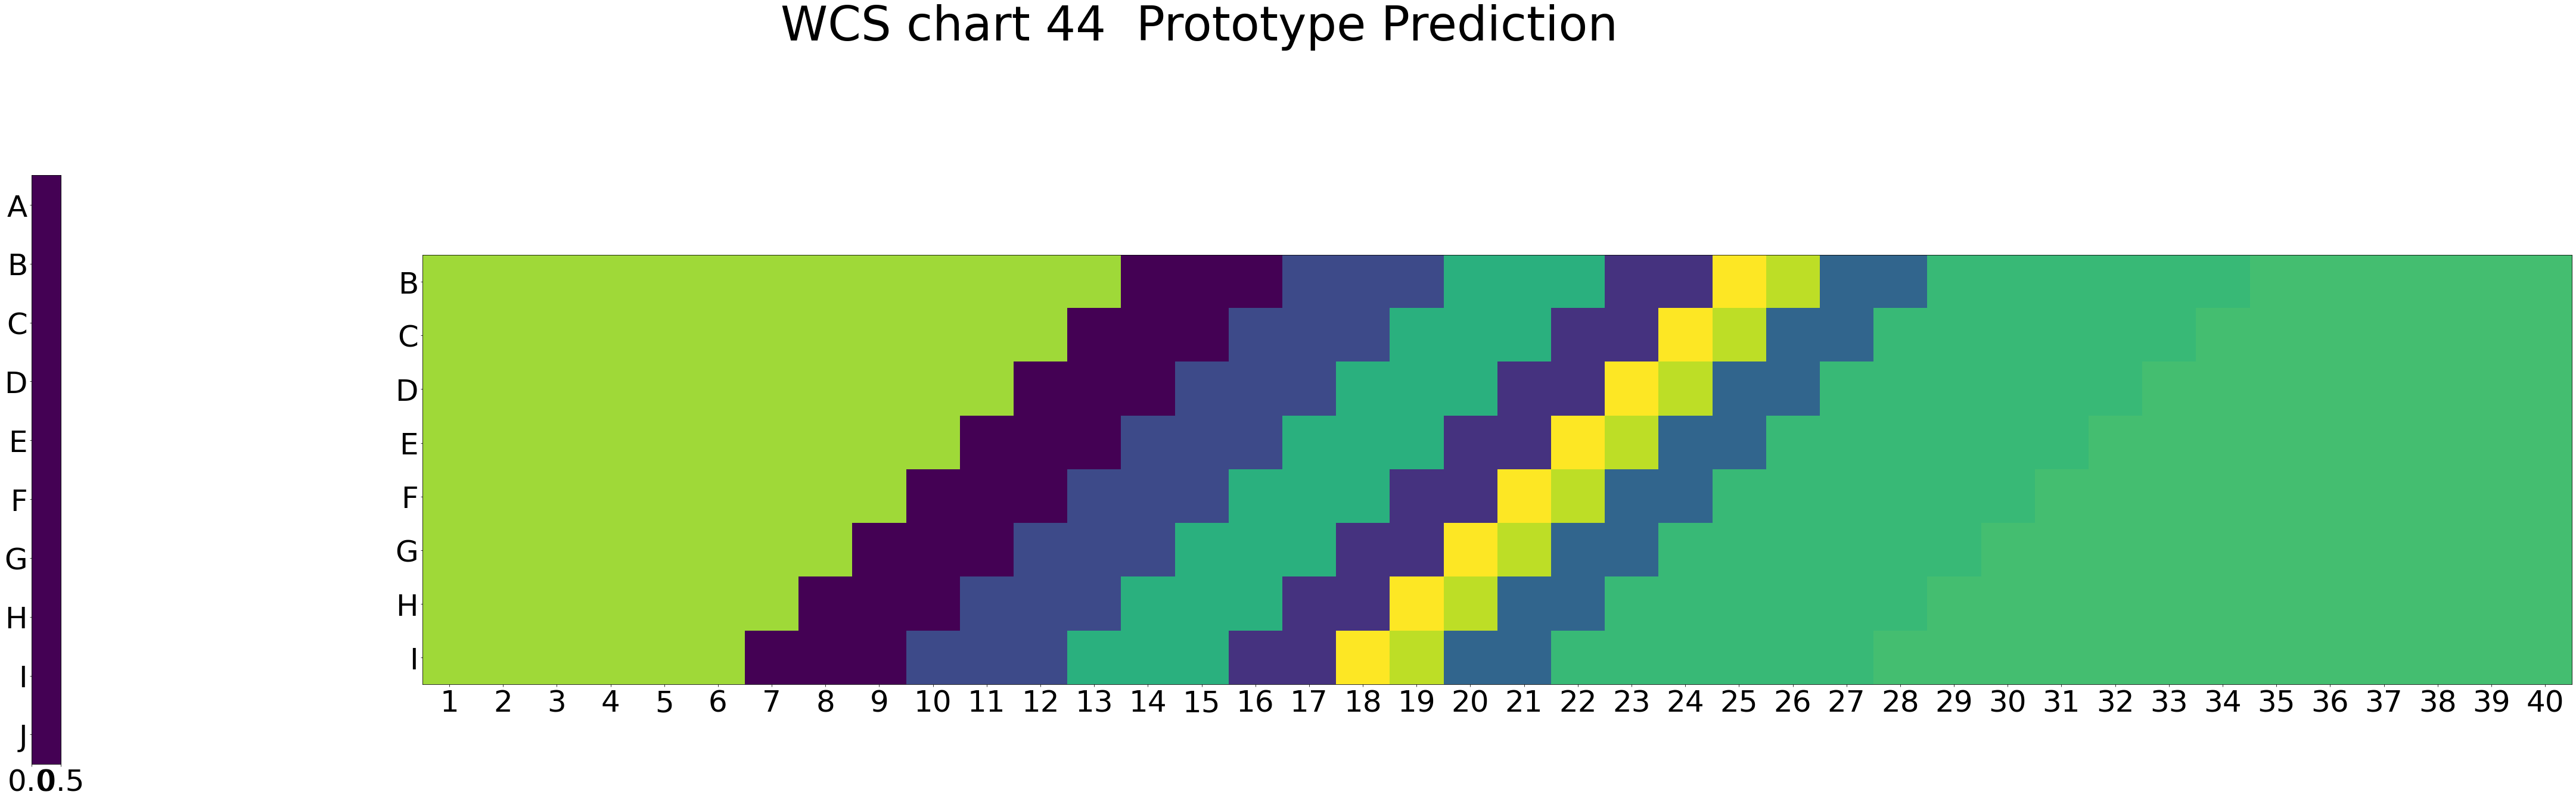

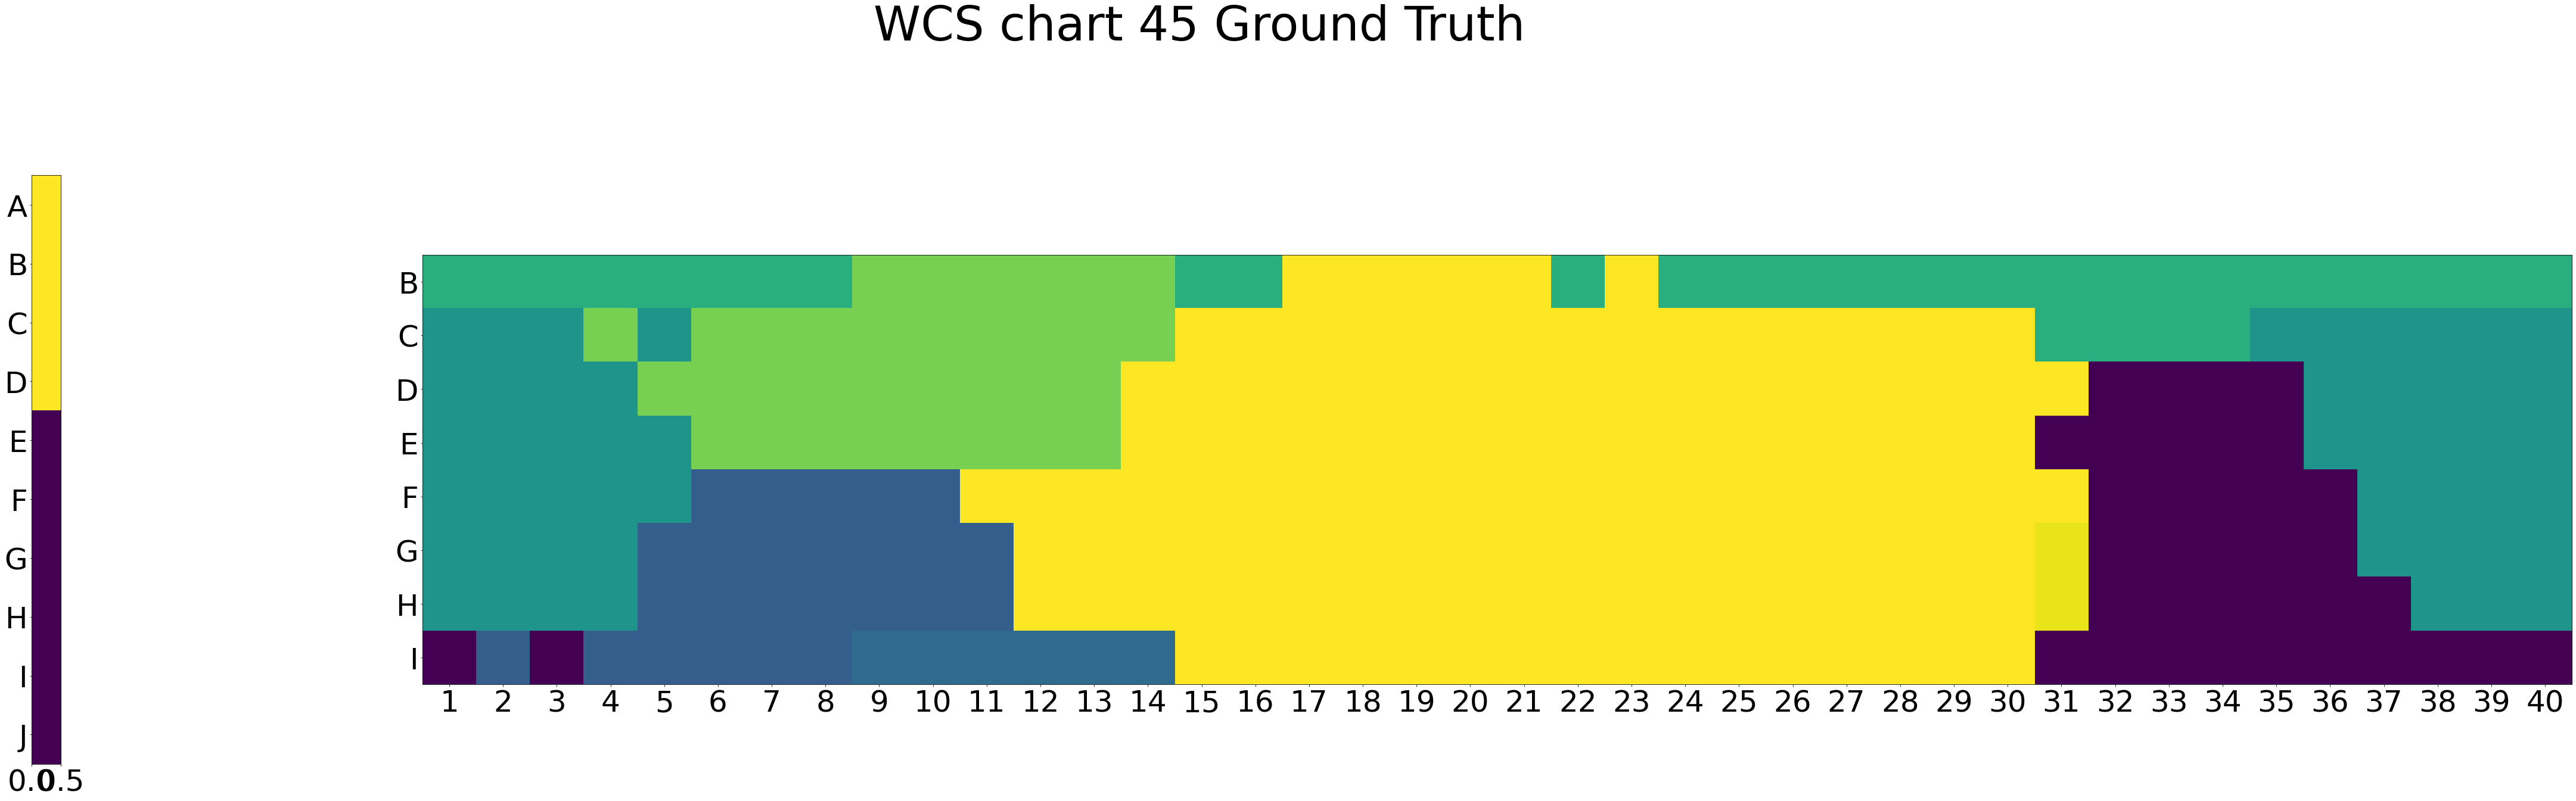

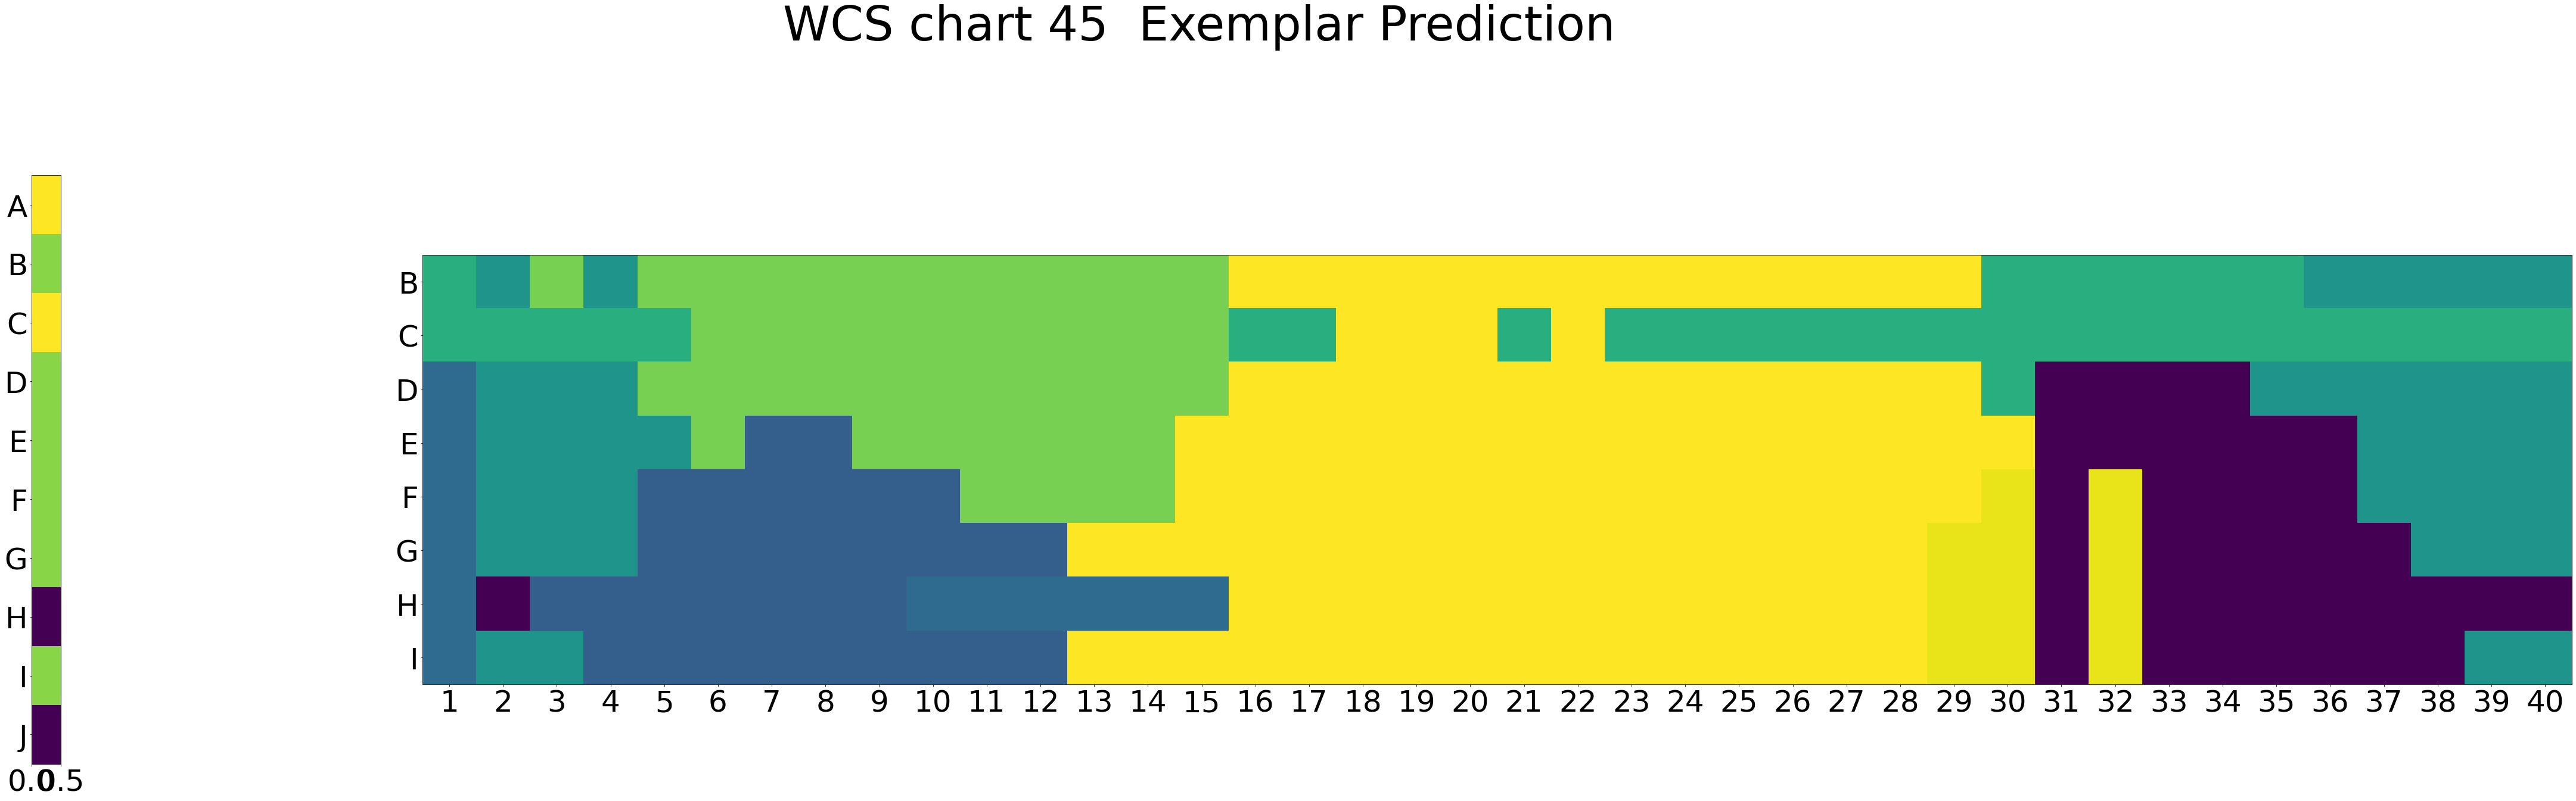

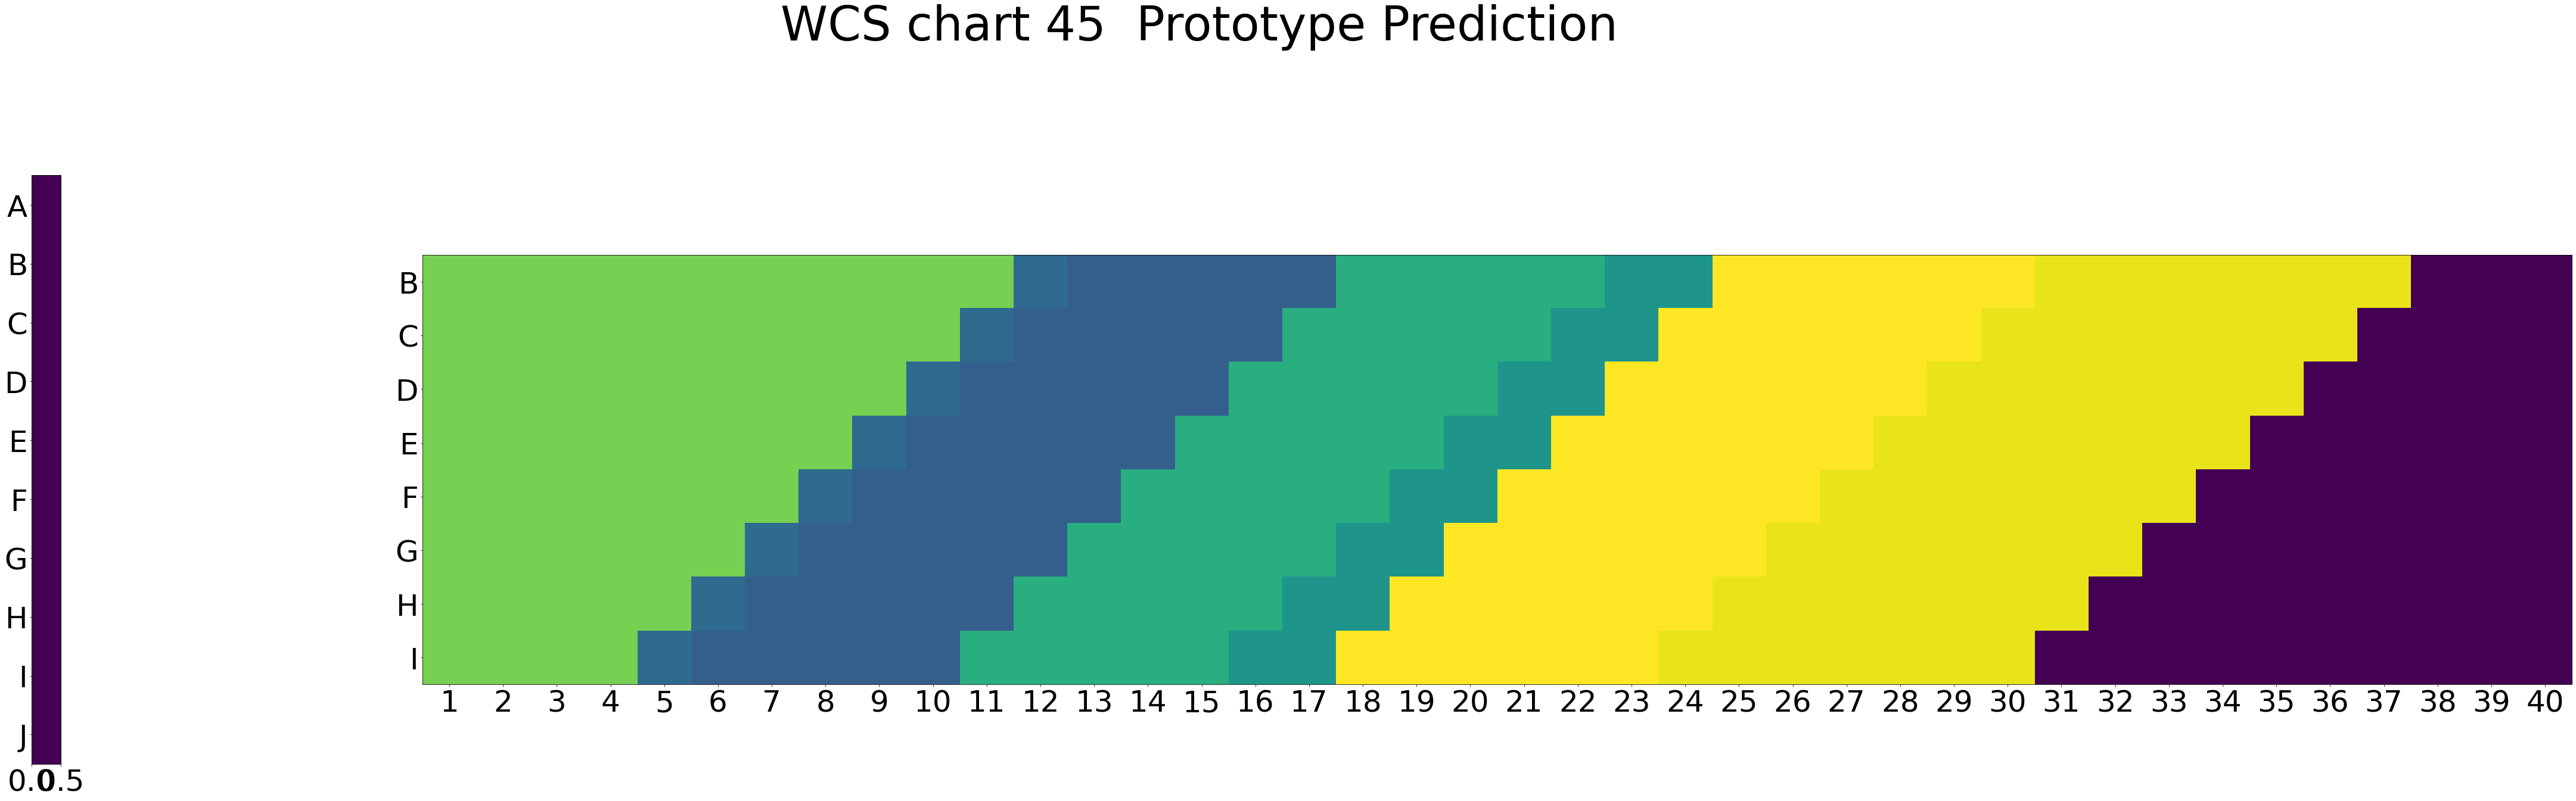

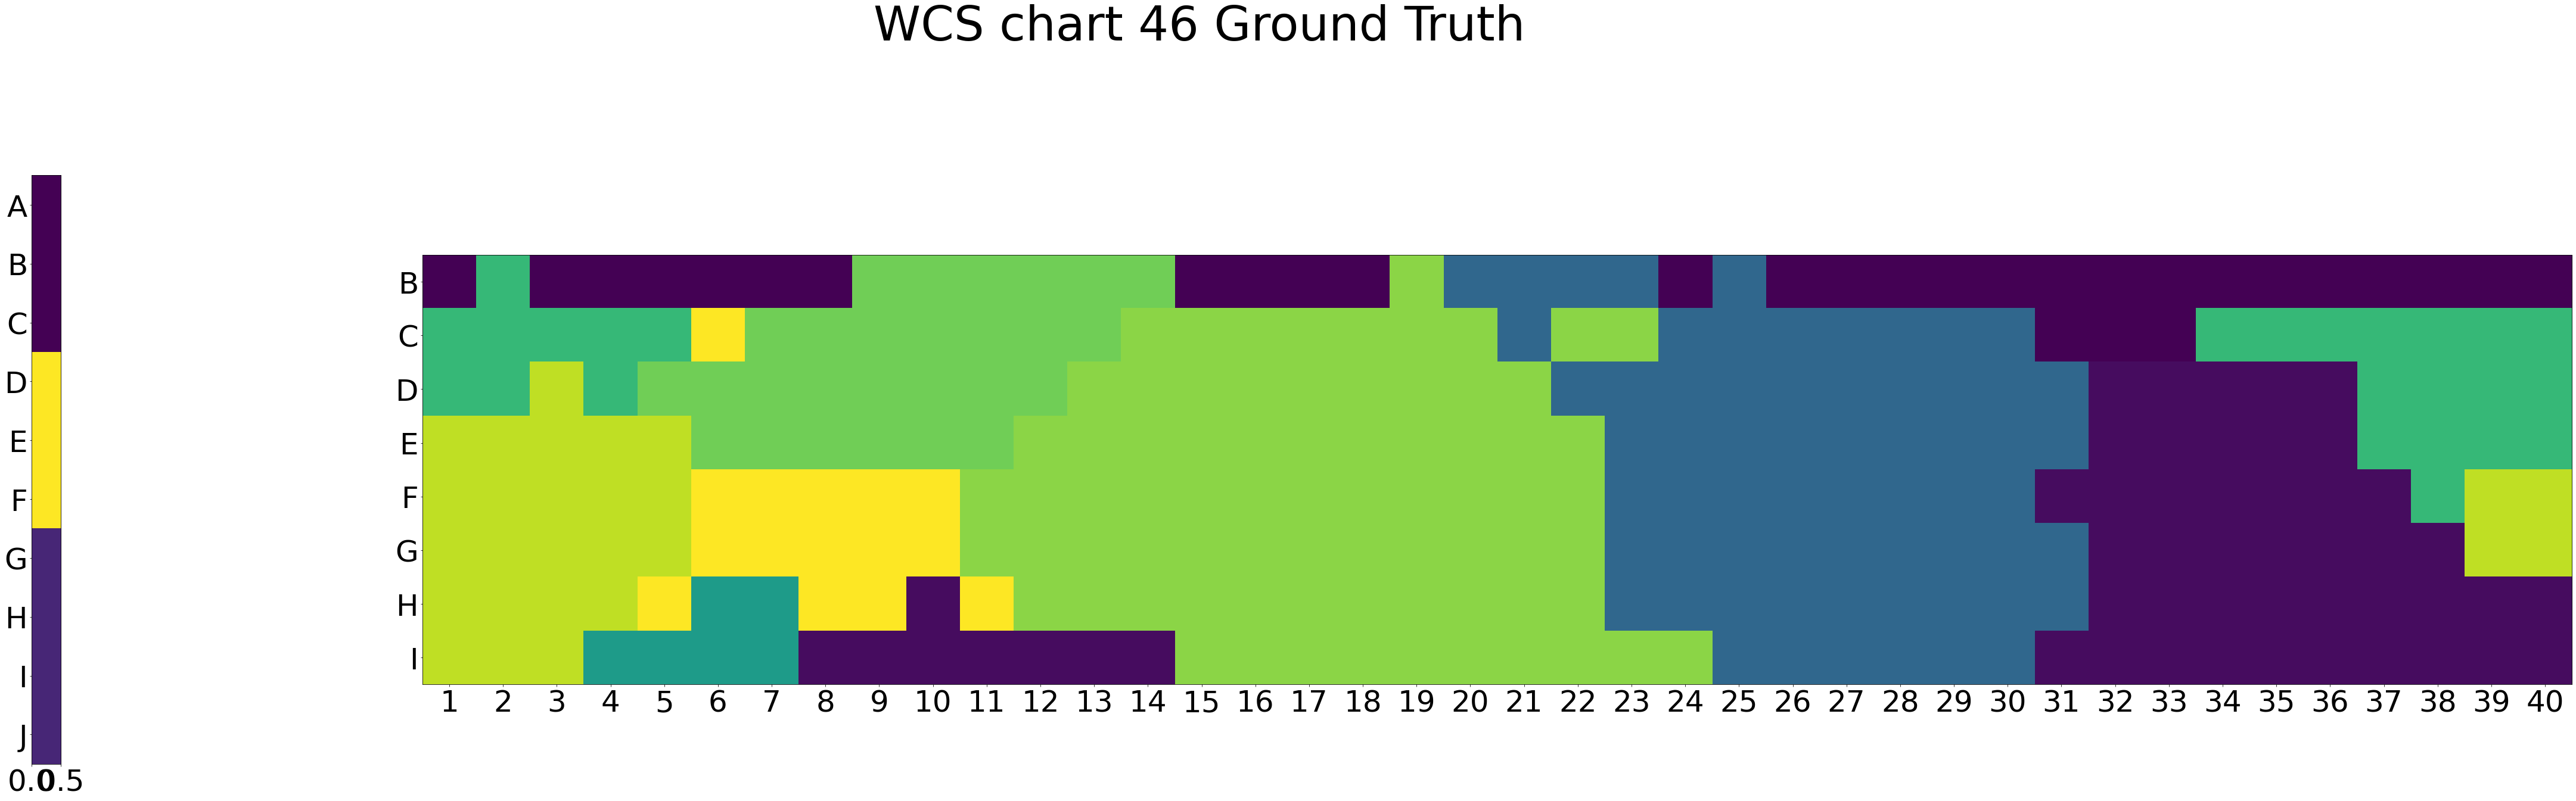

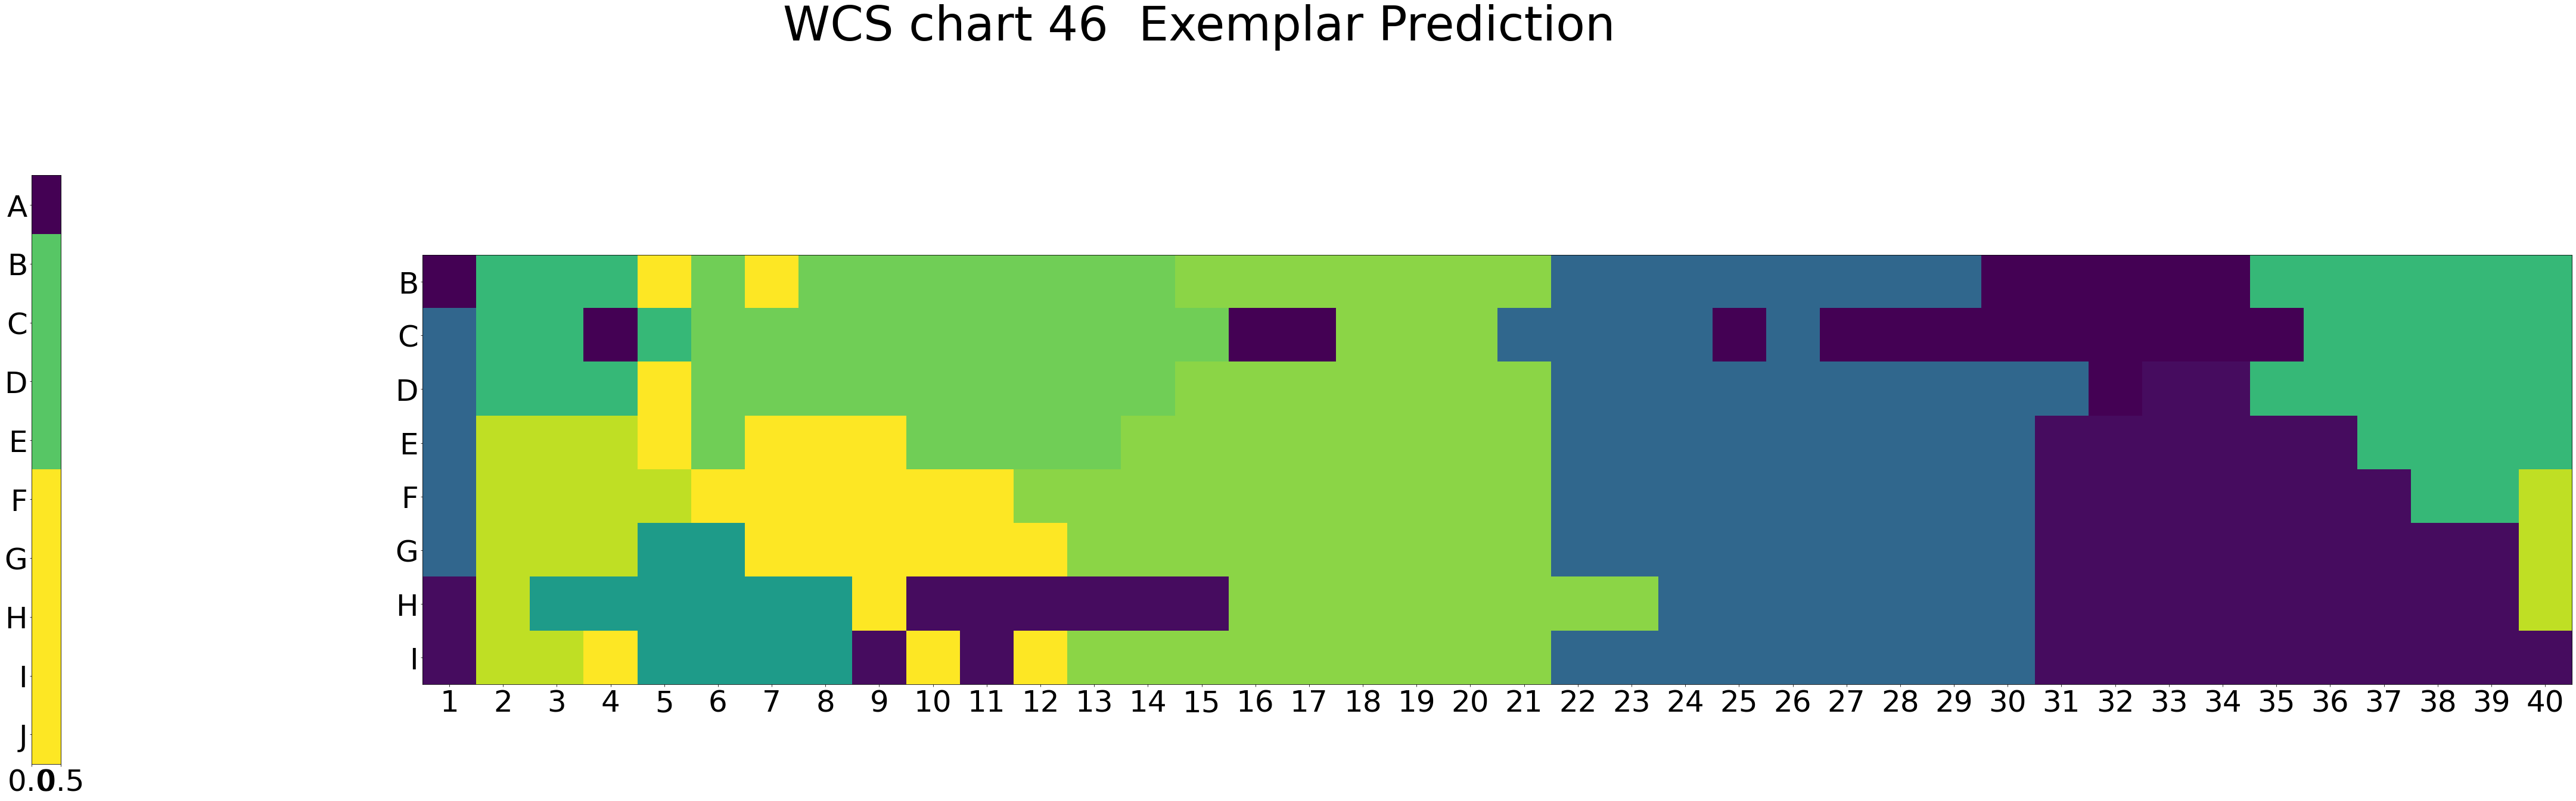

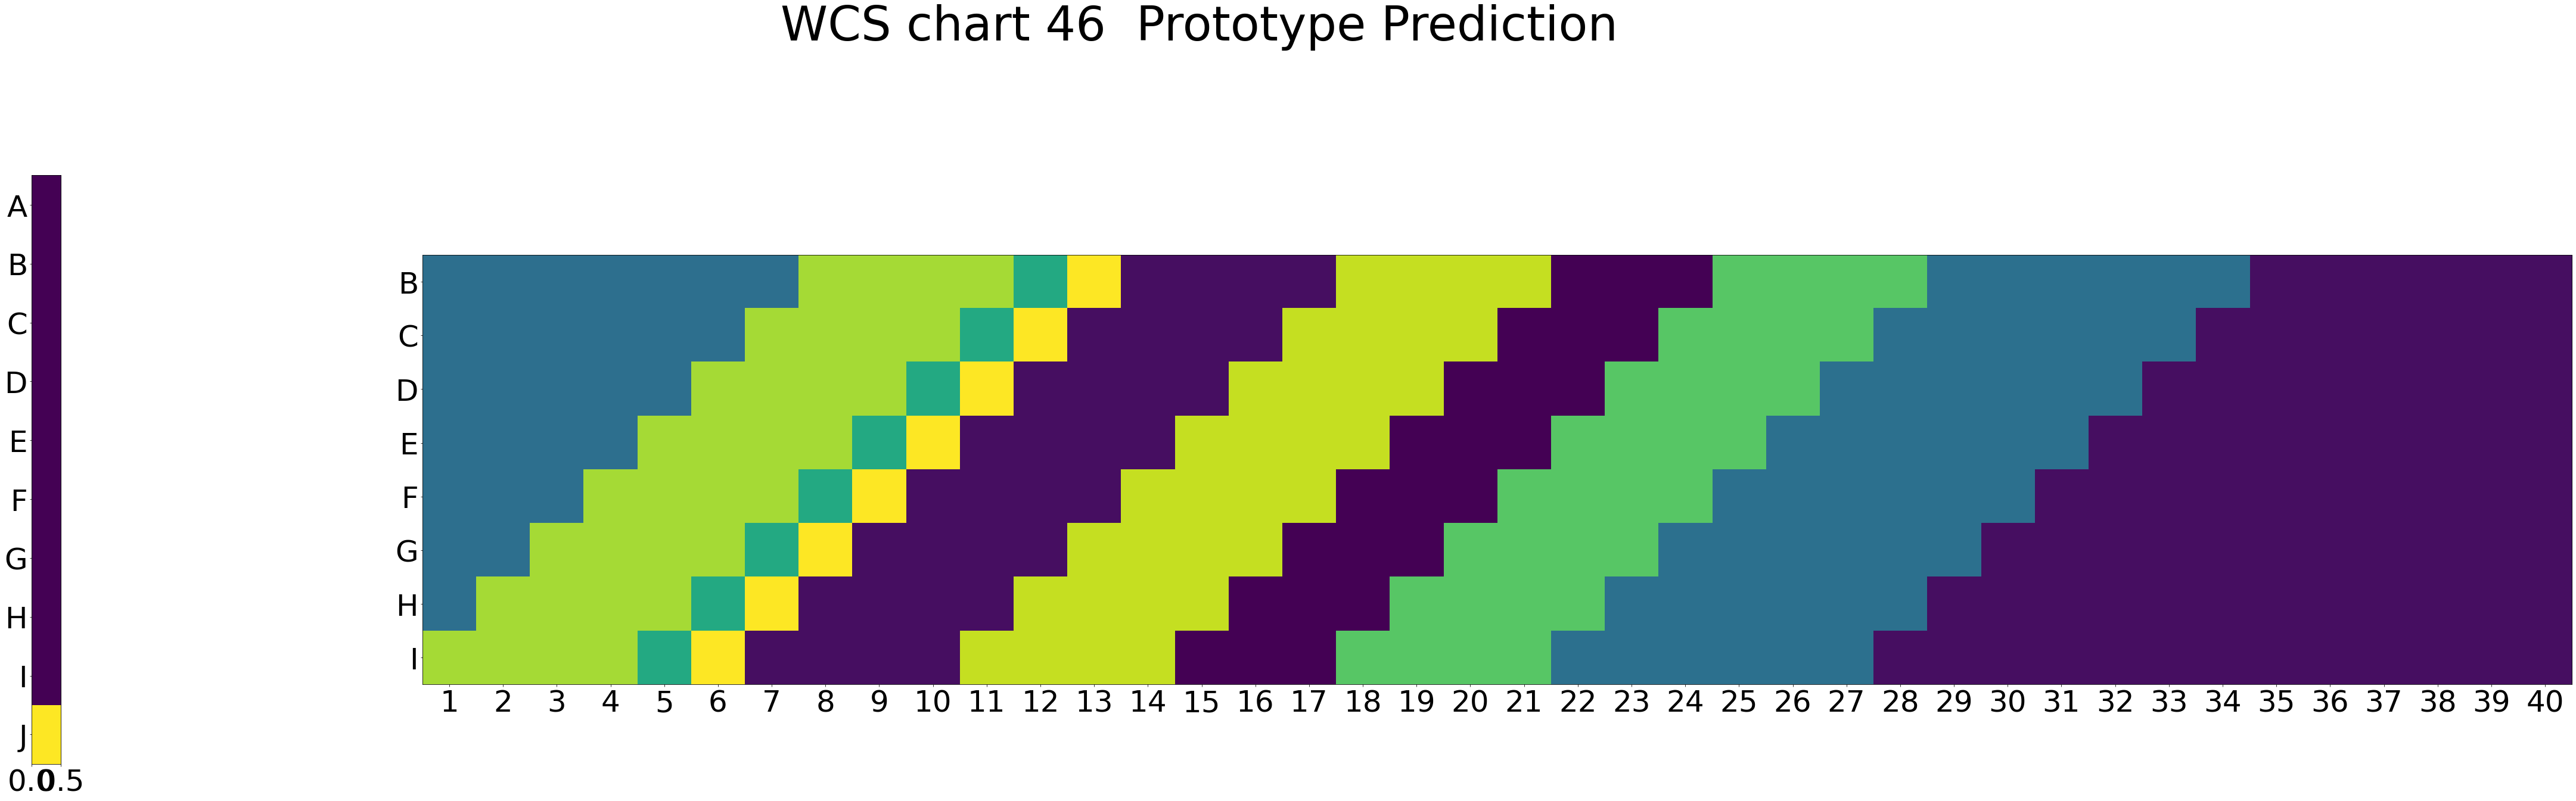

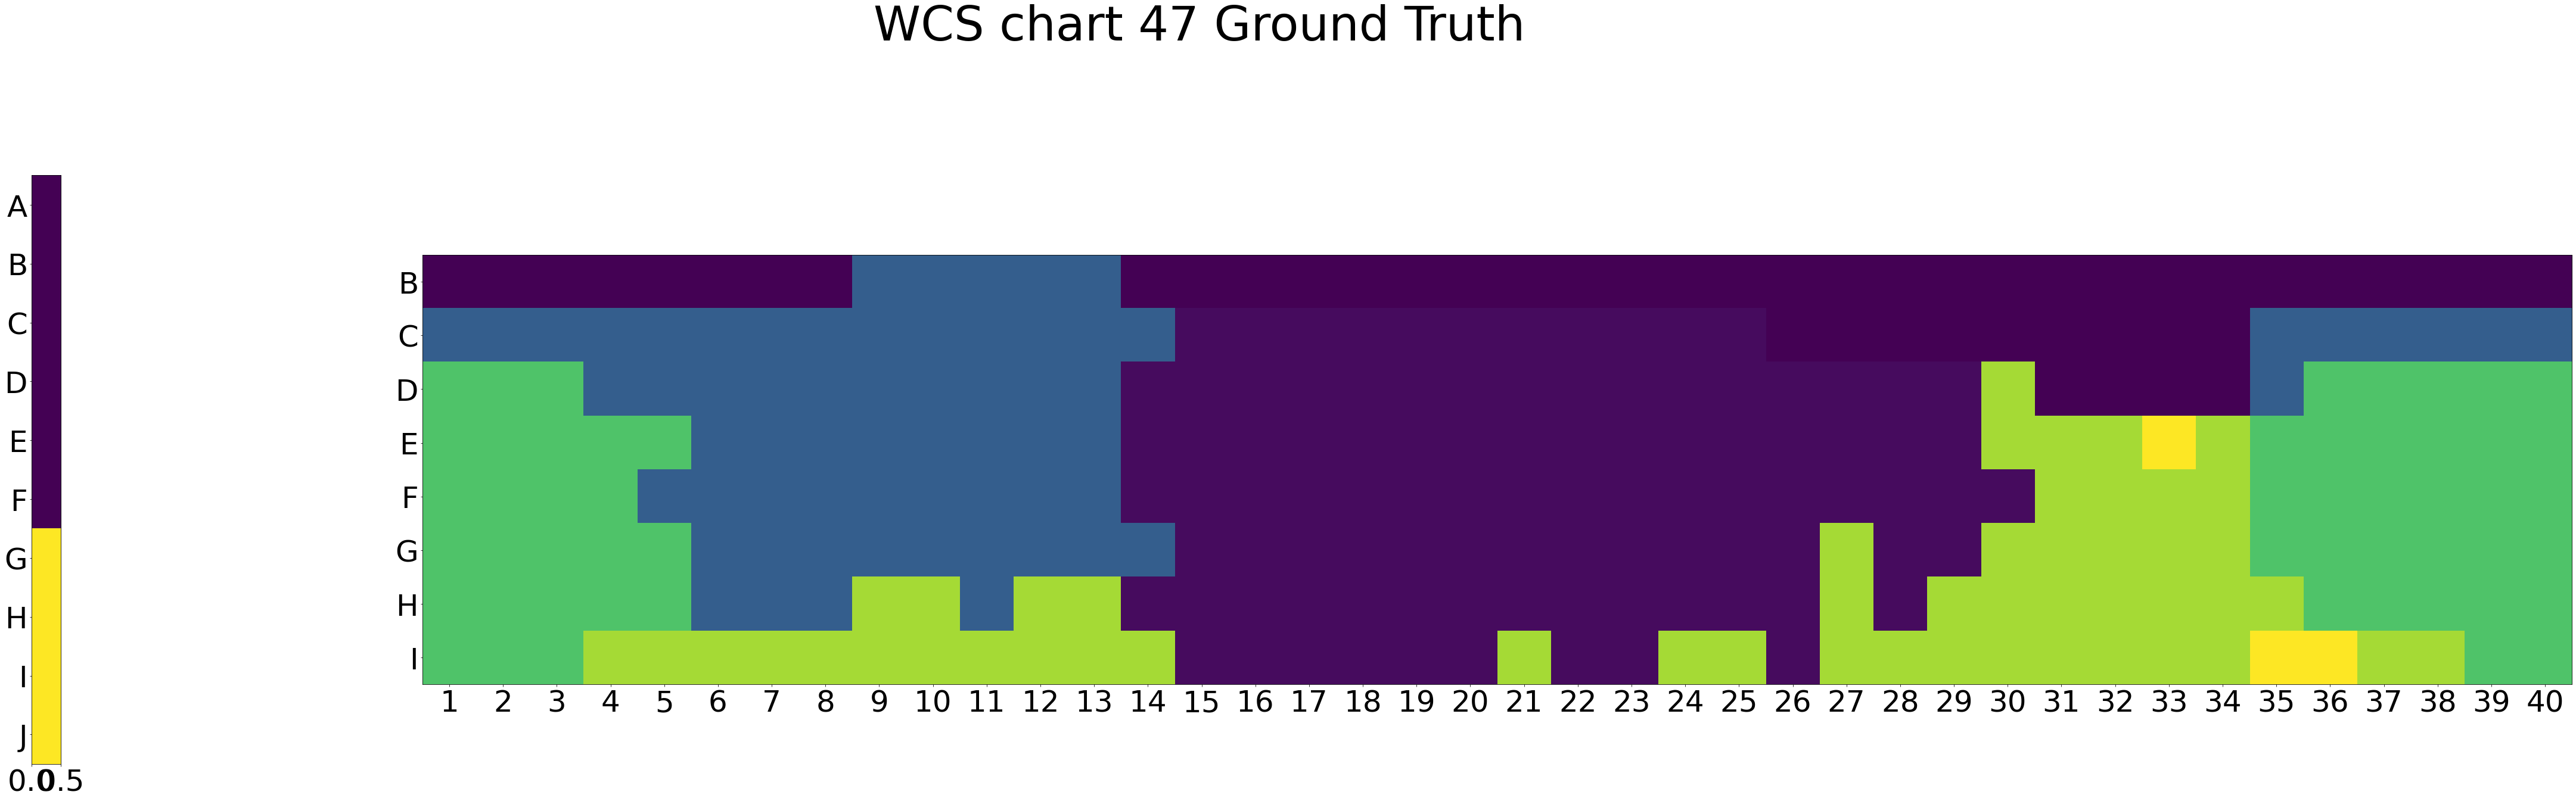

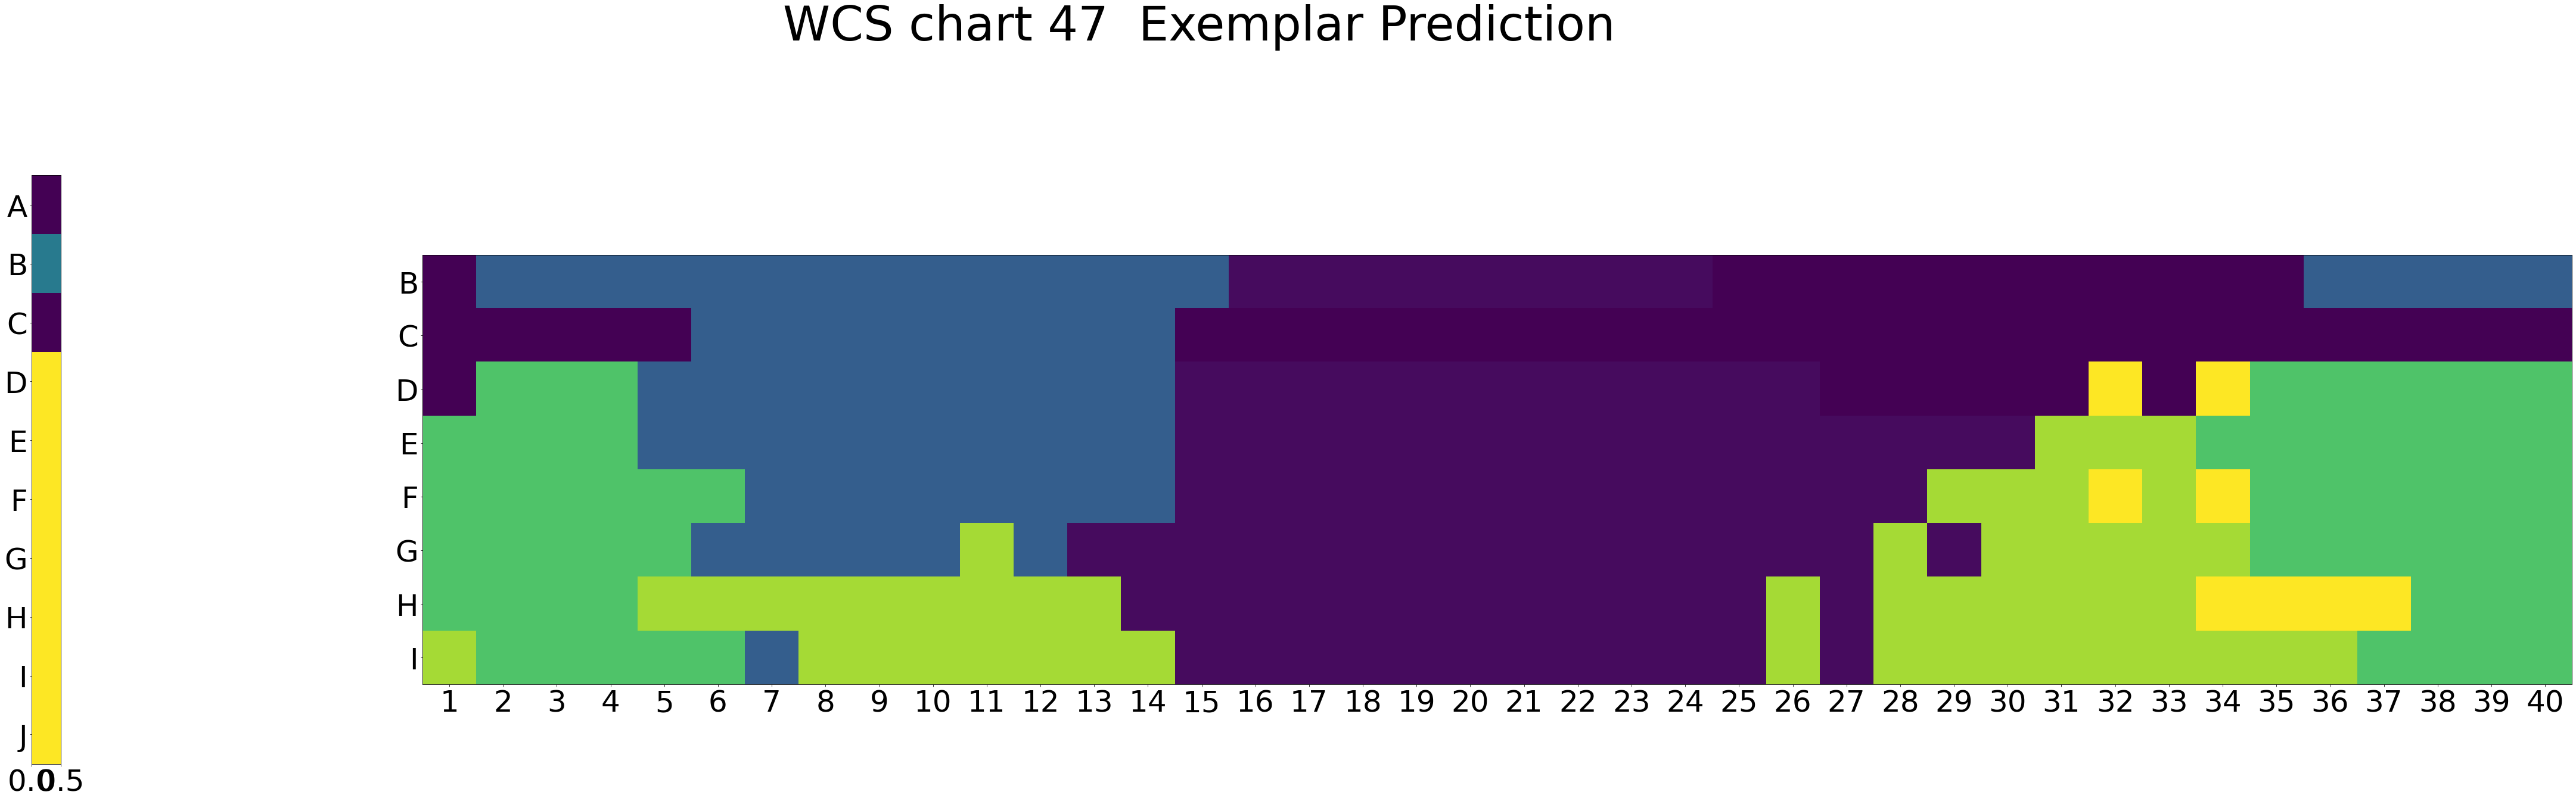

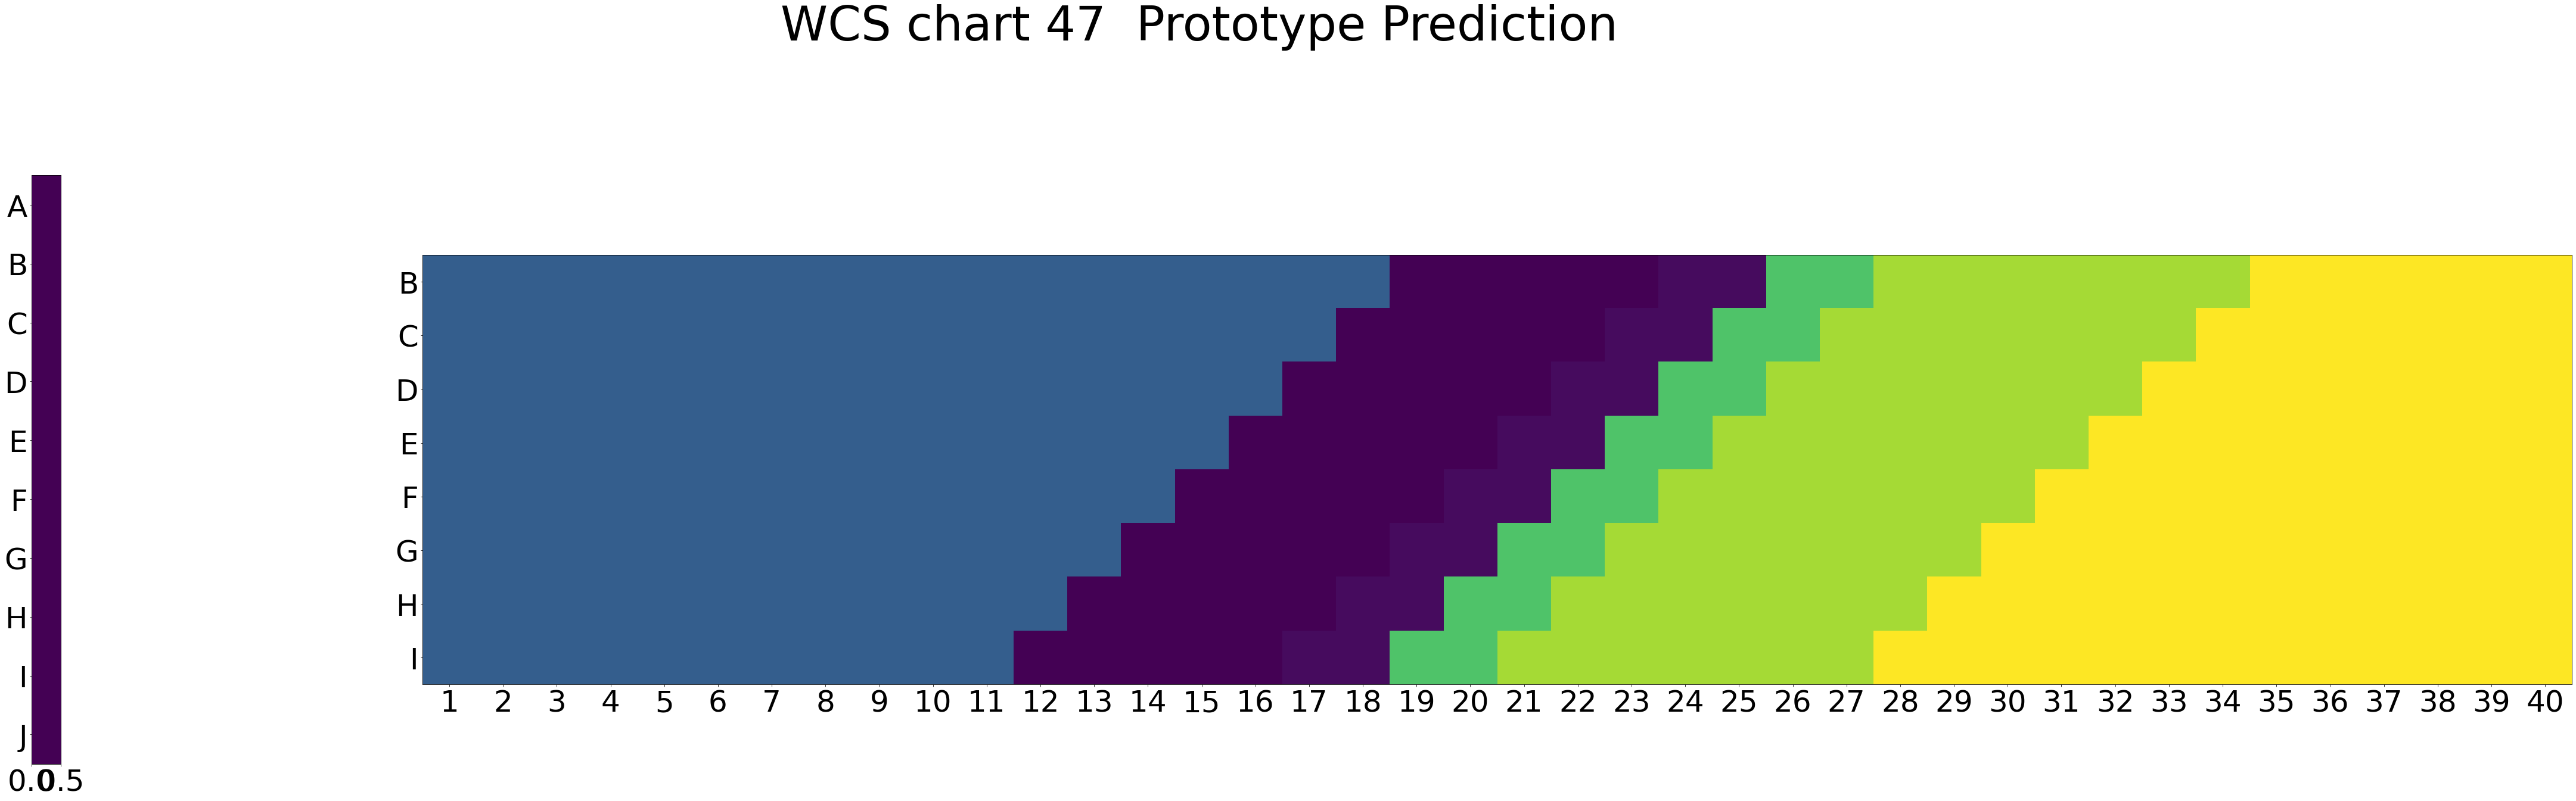

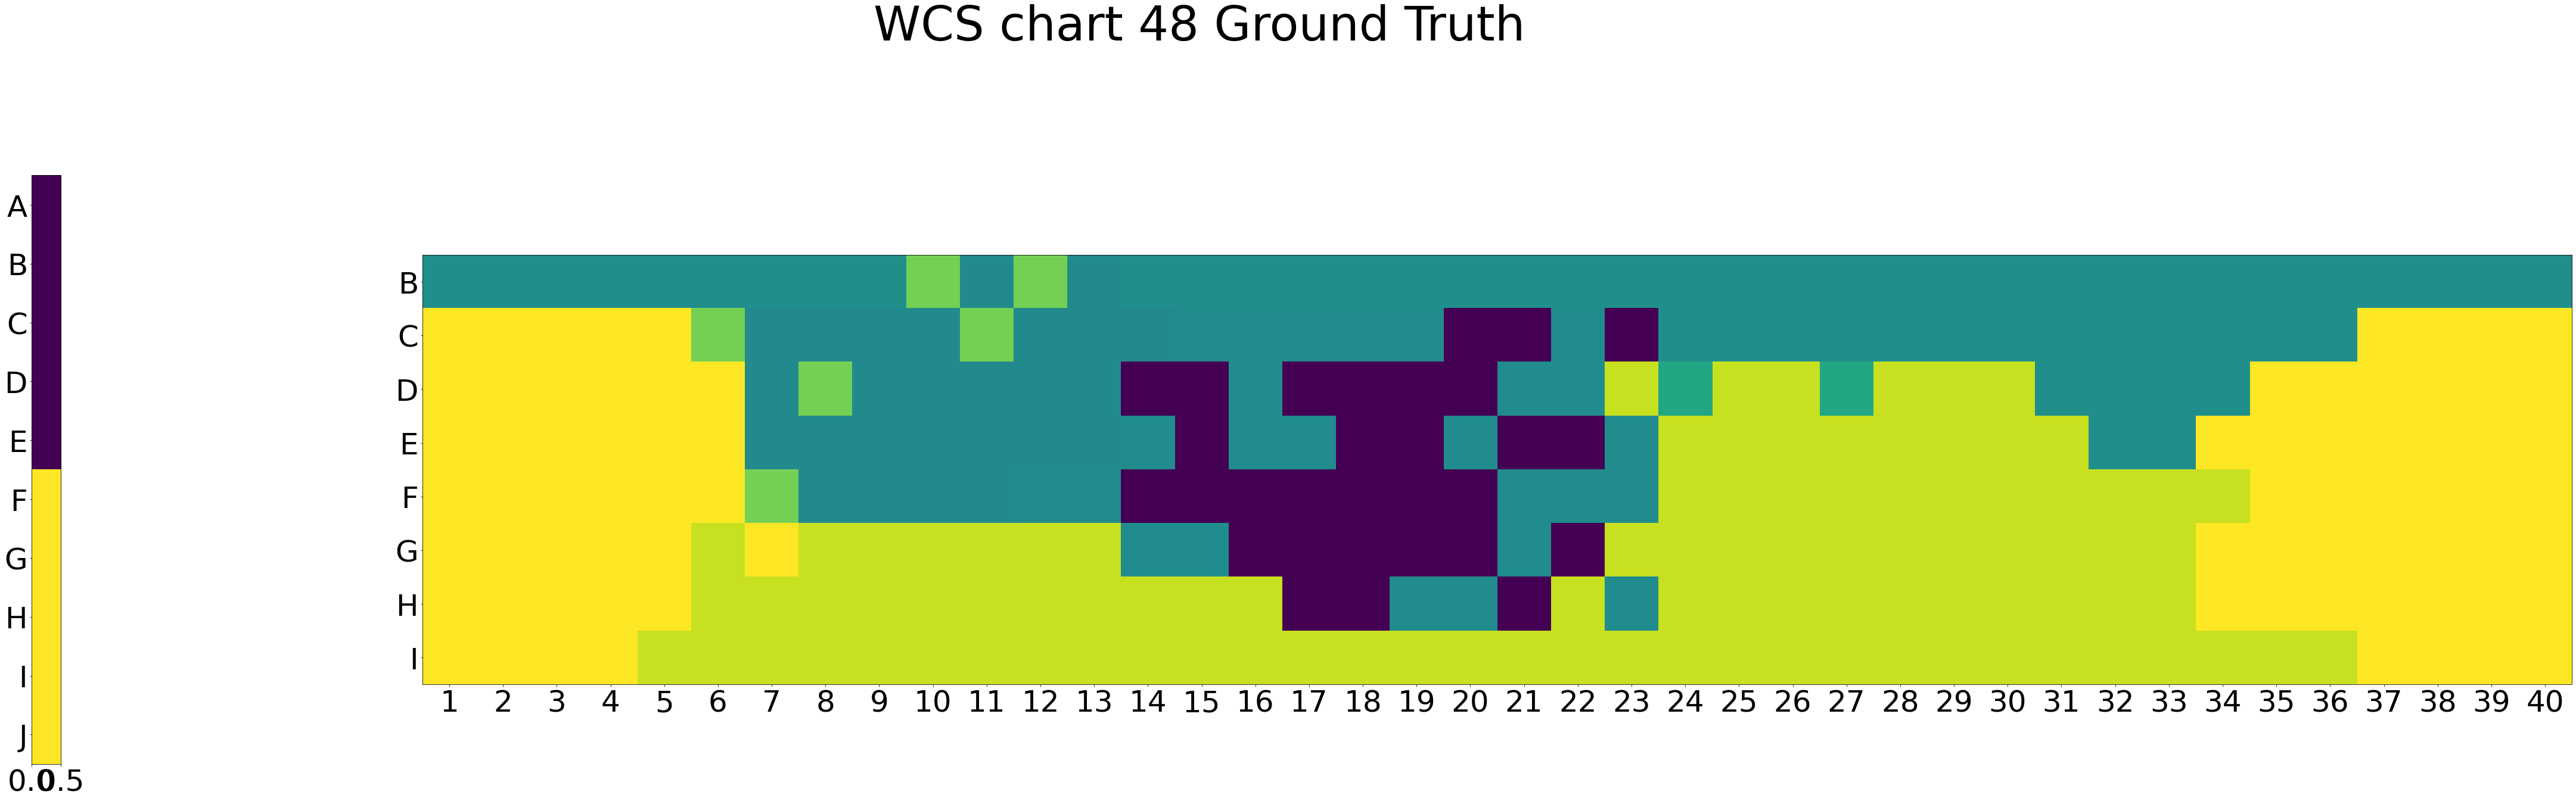

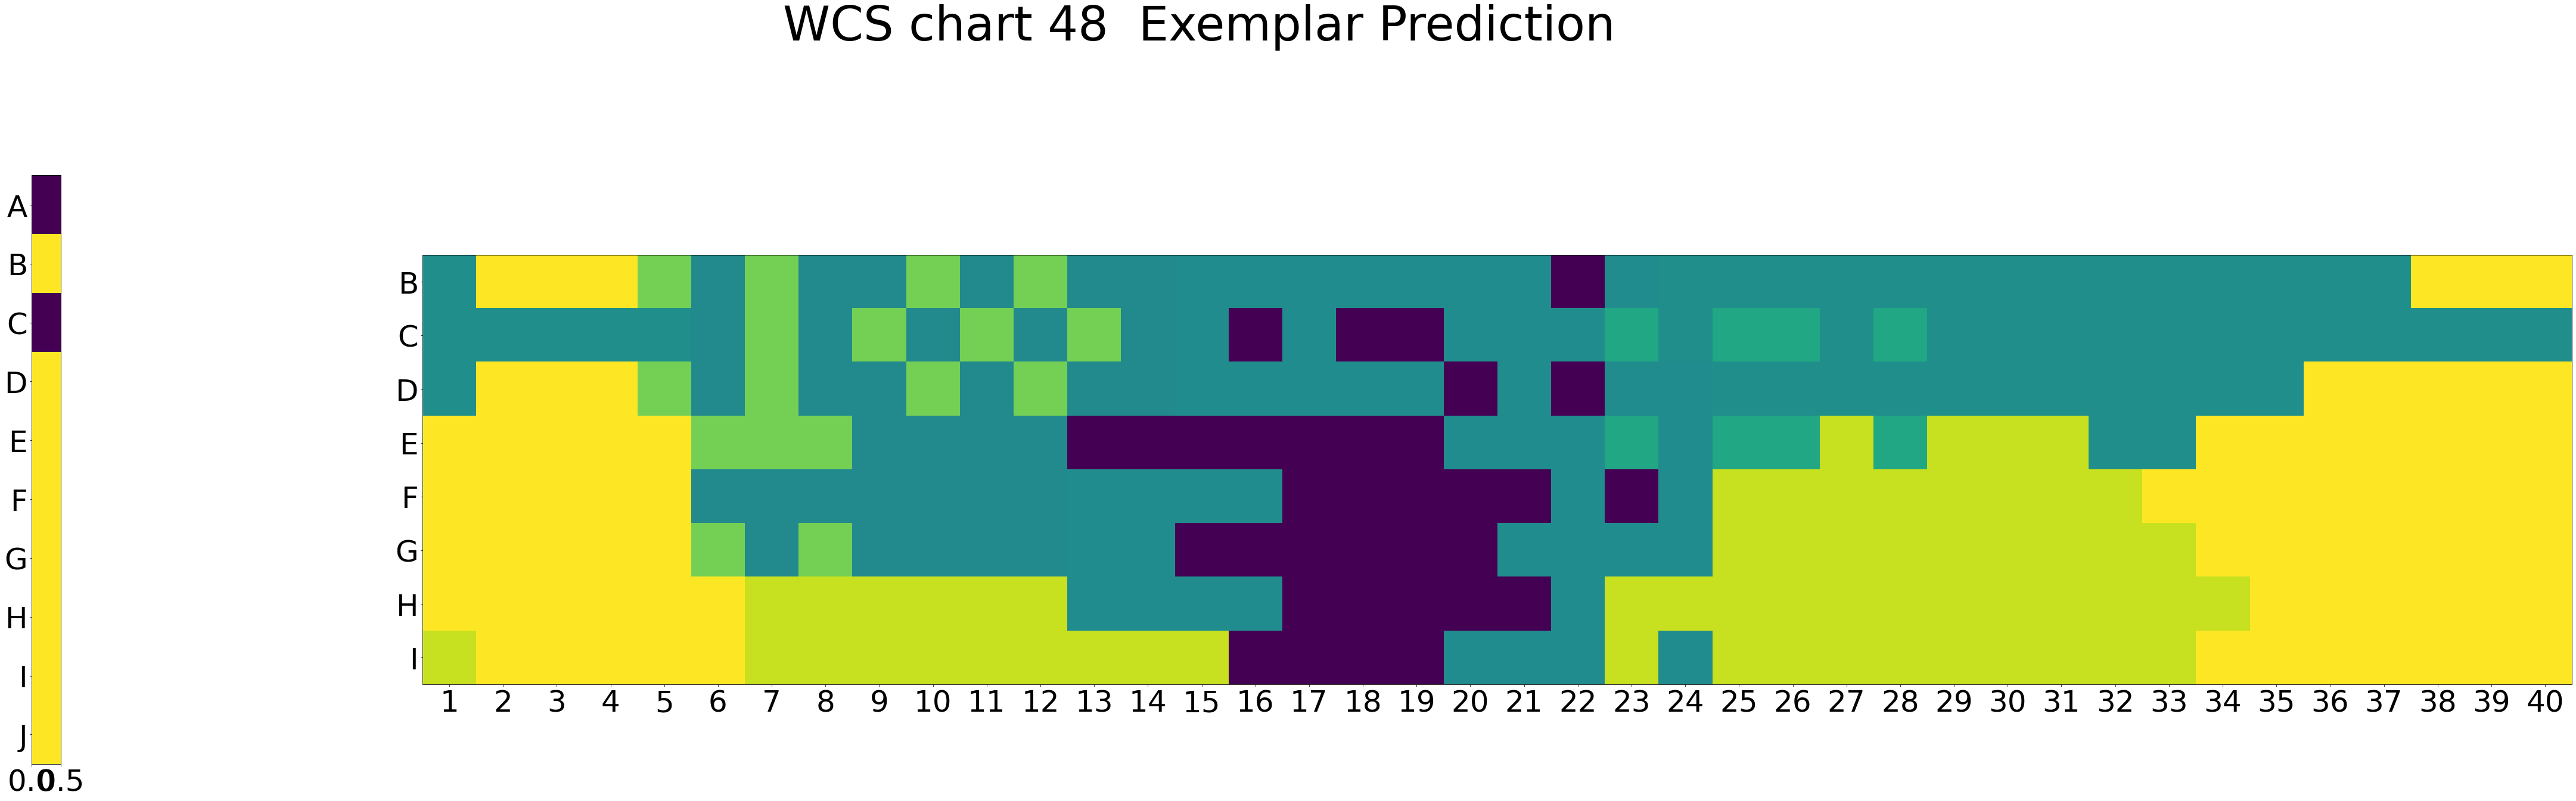

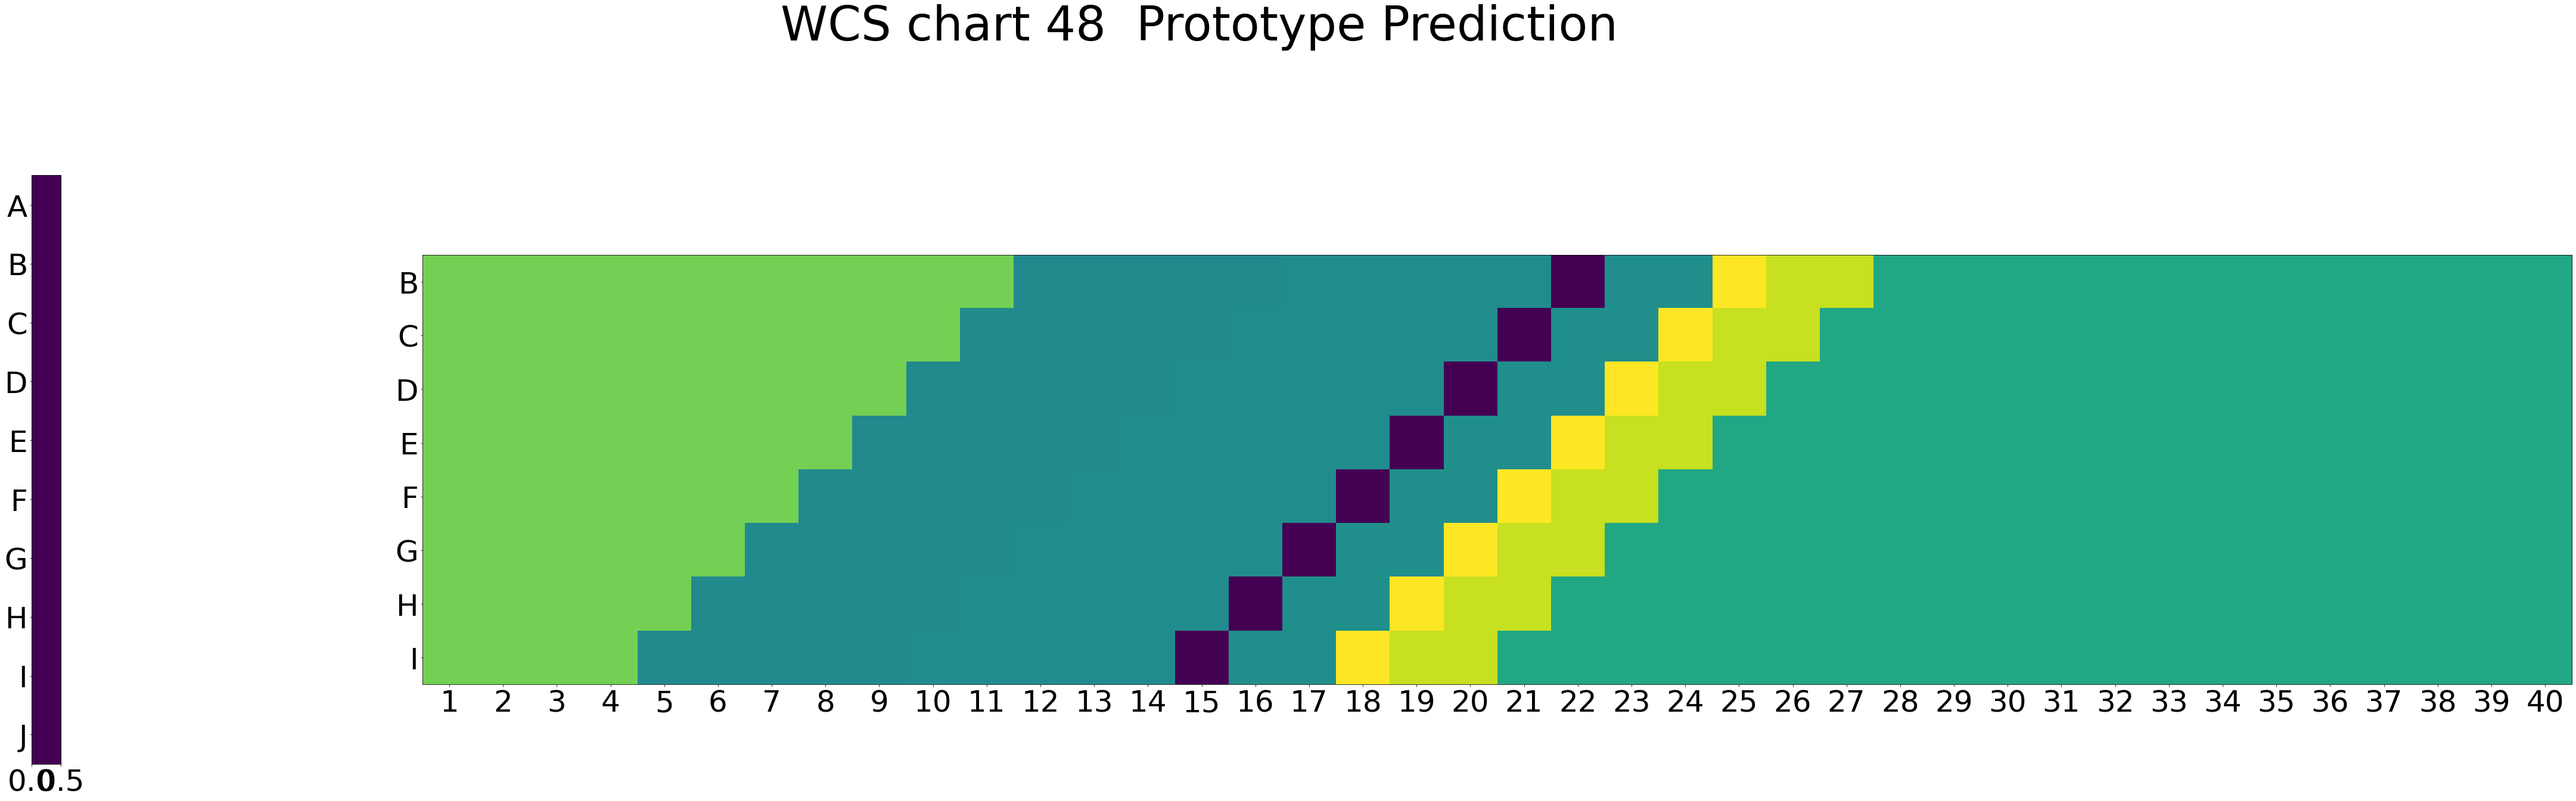

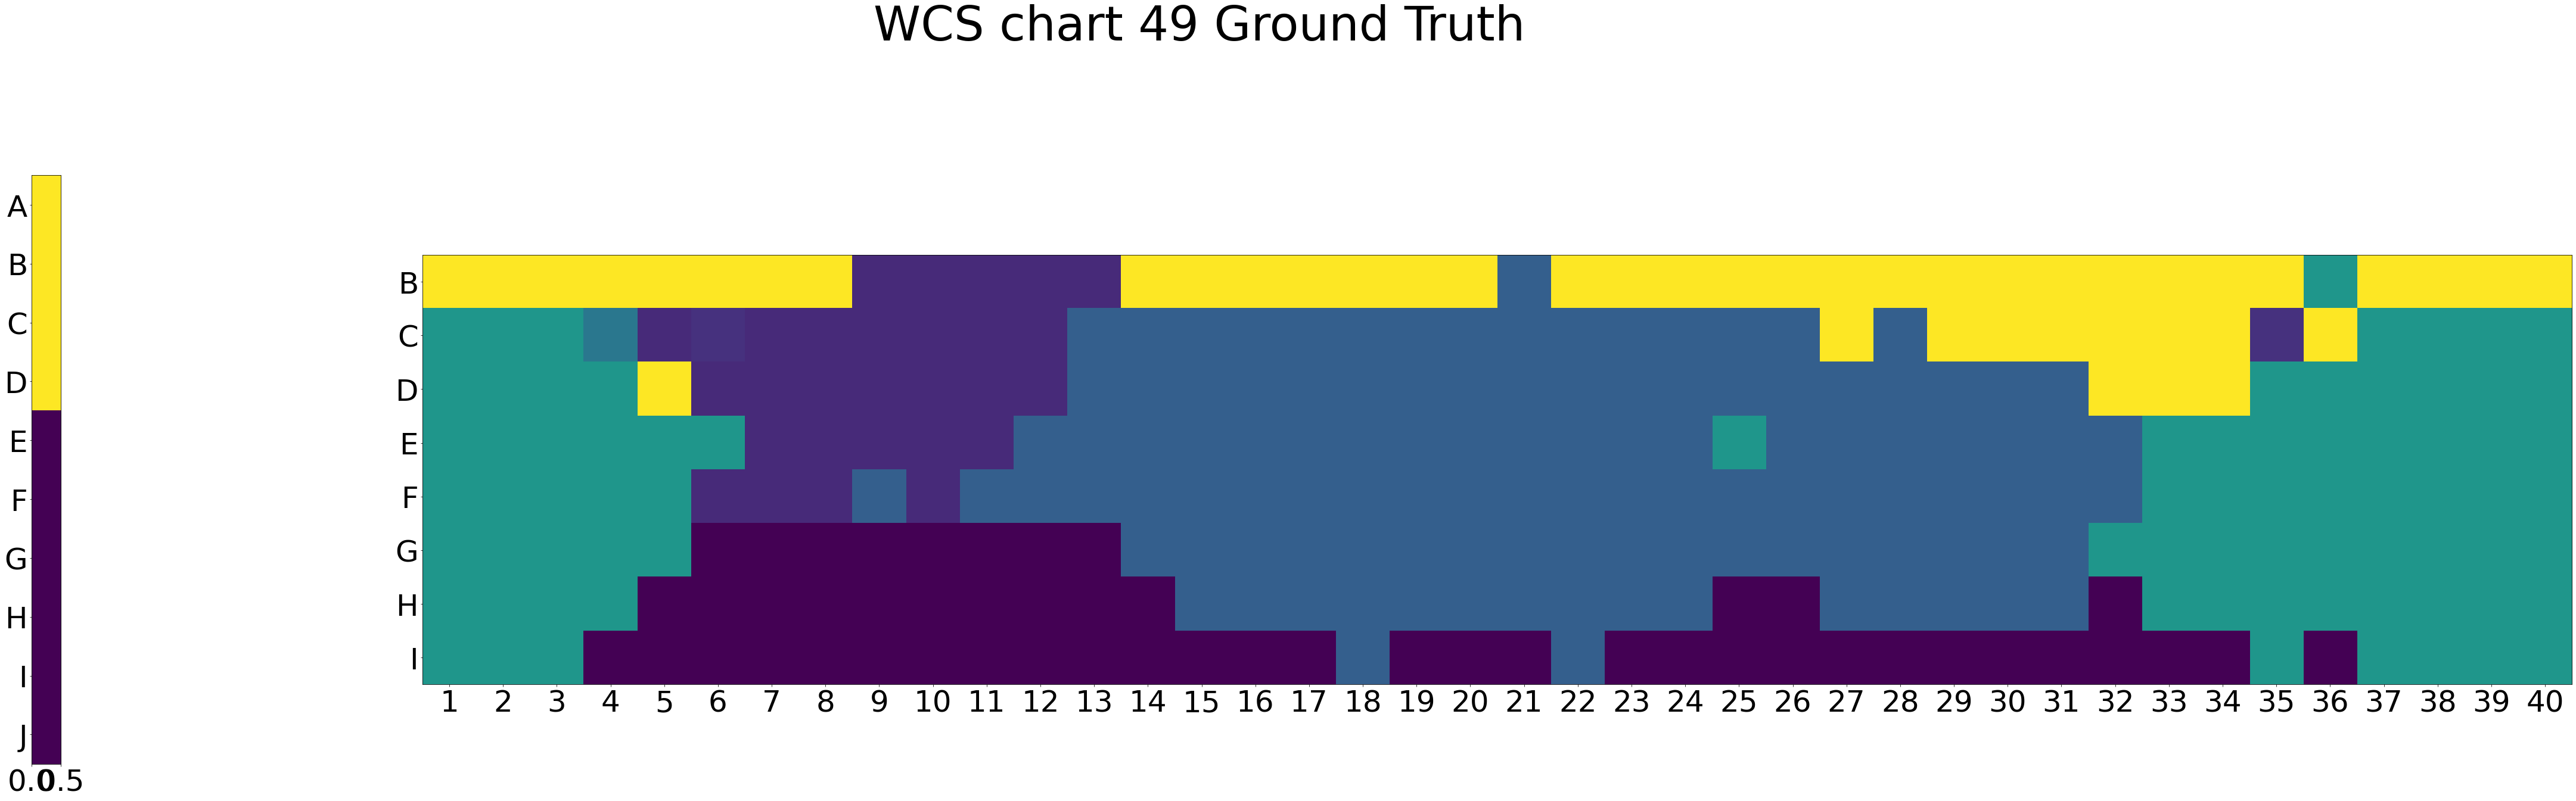

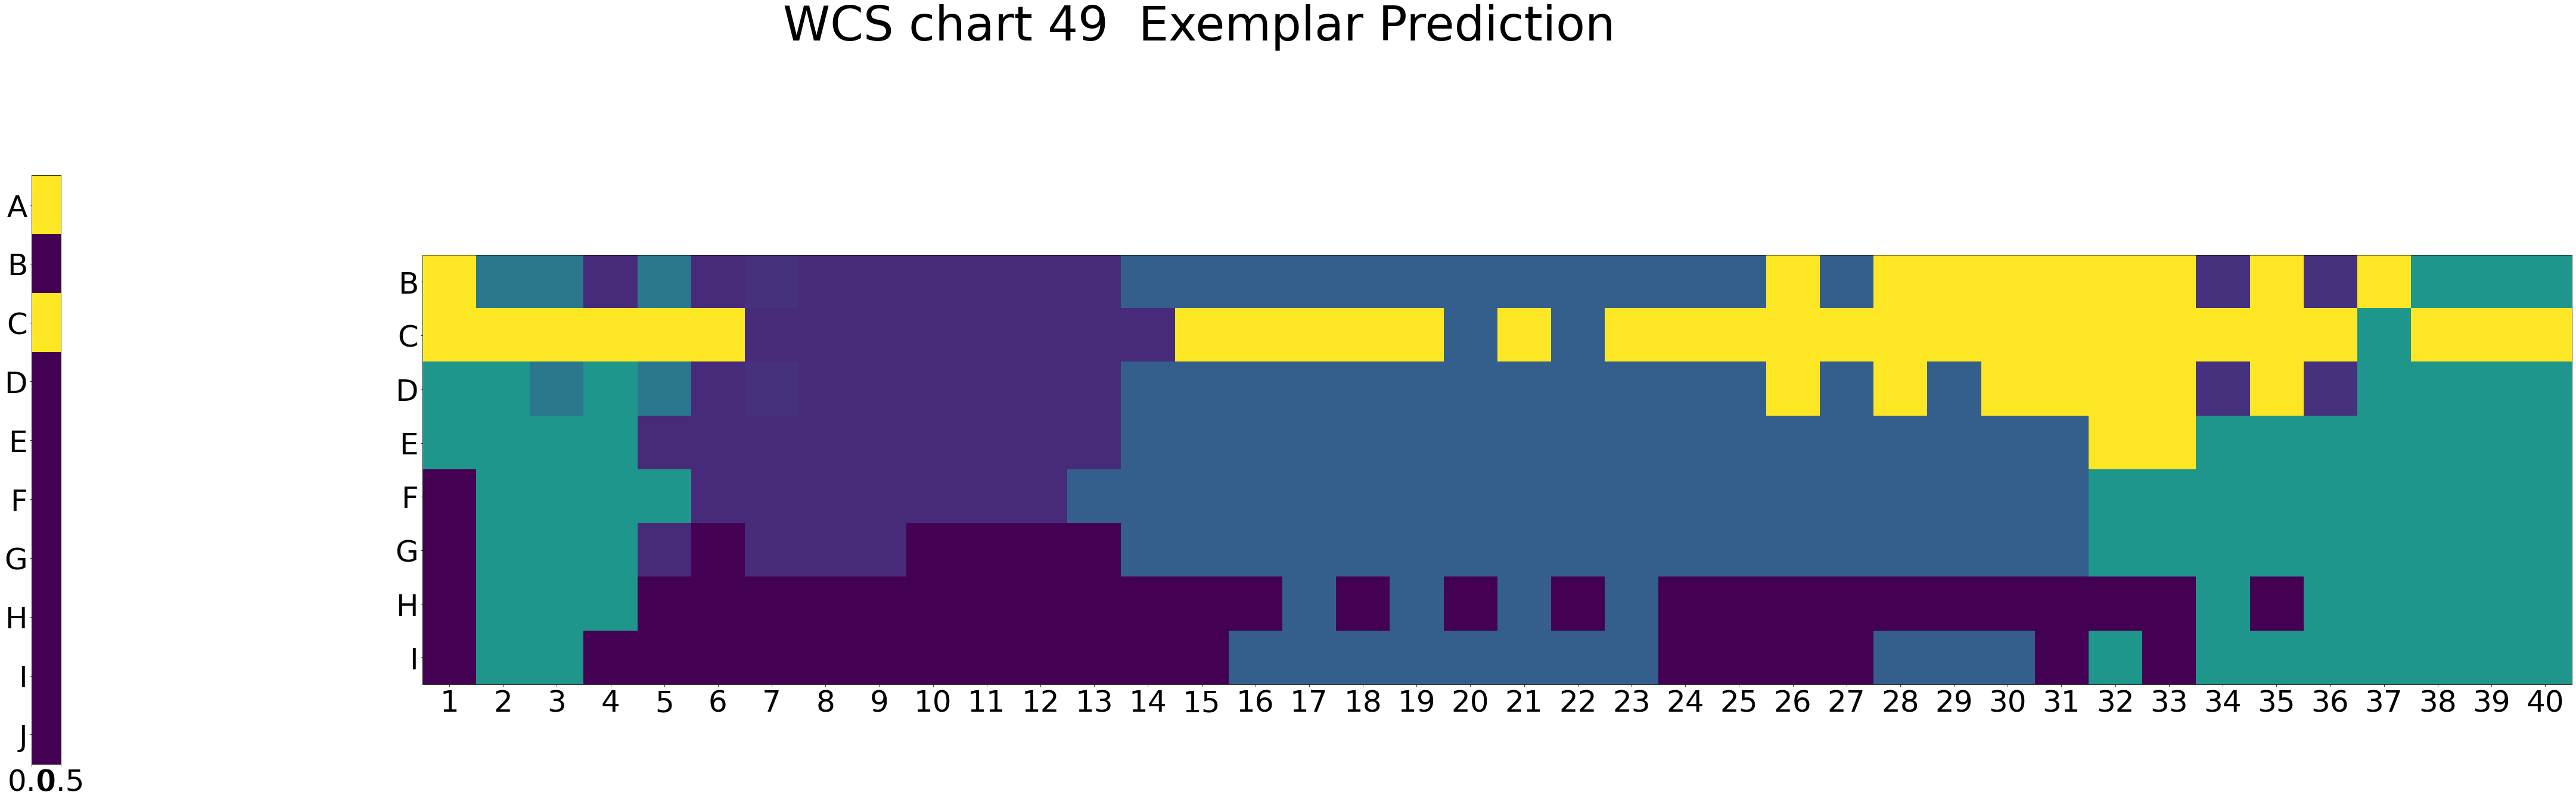

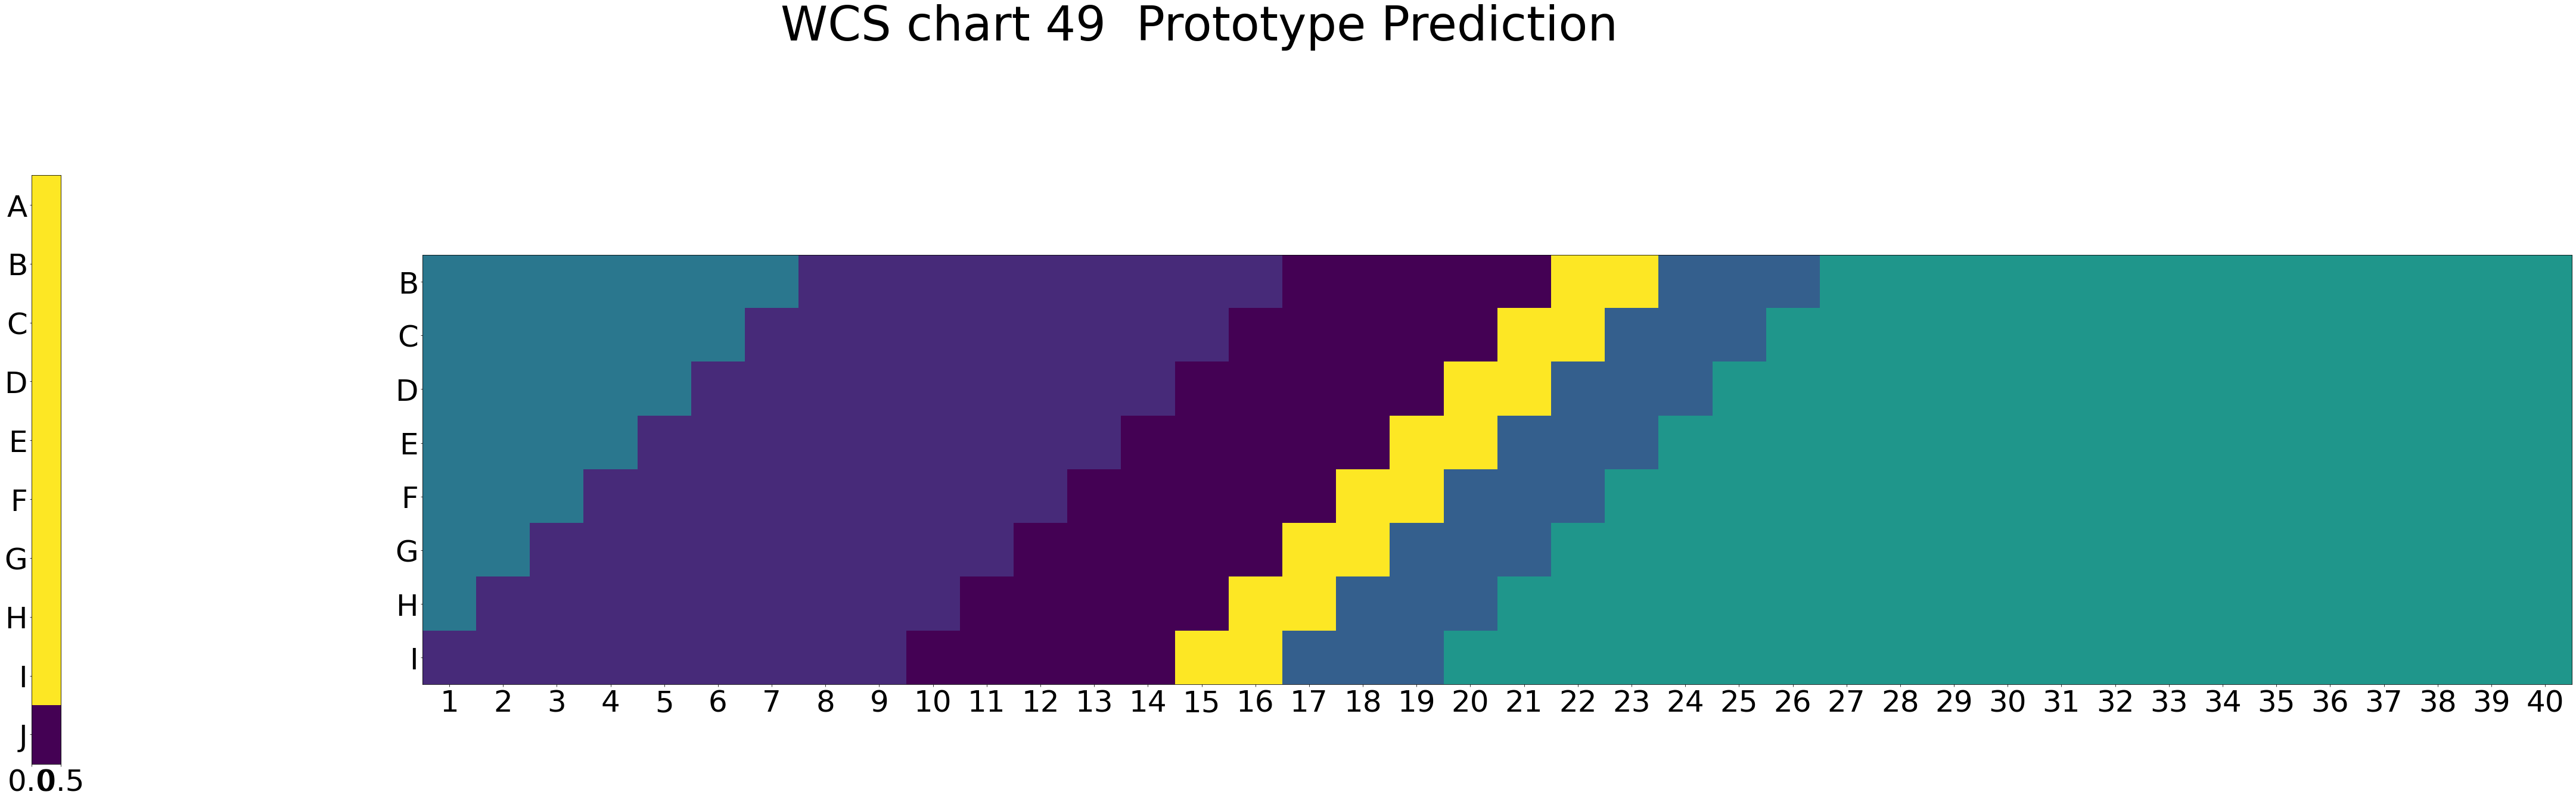

In [223]:
Eacc_list = []
Pacc_list = []
namingData = readNamingData('./WCS_data_core/term.txt')
create_visuals = True #### ENABLES VISUAL GENERATION, BUT INCREASE COMPUTATION TIME BY A LOT ####

for i in range (40, 51):    
    ground_truth = {}
    ground_truth_data = {}
    
    language = namingData[i]
    
    print ("=====================STARTING LANGUAGE: ", i, "================================")
    
    for k in language[1].keys():
        # Aggregate all given color terms for each chip   
        ground_truth_data[k] = tuple(d[1][k] for d in language.items() if d[1][k] != "*")
        if is_empty(ground_truth_data[k]):
            ground_truth_data[k] = '*'
    
    for k in ground_truth_data:
        # choose the color term that appears most frequently as our ground truth value for each chip.
         ground_truth[k] = stats.mode(ground_truth_data[k])

            
    # Our labels for each color chip 
    labels = np.array([chip[1].mode[0] for chip in ground_truth.items()])    
    # print (labels)
    

    # All unique color terms from the ground truth. These determine our "categories"
    color_terms = list(set(labels))

    print ("Color categories:", color_terms)

    # Construct feature matrix
    F = [indexCoord[k] for k in range(1,331)]

    # print (np.array(F))
    
    # Lightness variable is a letter, lets convert this into an integer.
    F = np.transpose(F)
    # print (F[0])
    light_num = [int(ord(letter)-64) for letter in F[0]]
    F = np.transpose([light_num, F[1]])

    terms_inds = {}

    # Convert coordinates into tuple(int,int) THIS WILL ONLY WORK FOR MUNSELL SPACE, IF YOU WANT TO DO CIELAB, YOU NEED TO MODIFY
    F = [tuple([int(coord[0]), int(coord[1])]) for coord in F]

    # print (F)
    
    # now we create a dict{str:[tuple(int,int)]} where str is our color term/category and it's value is a list of color chips (in form of munsell space coordinates) that have been labeled with str
    for ind, term in enumerate(labels):
        if term not in terms_inds:
            terms_inds[term] = [F[ind]]
        else:
            terms_inds[term].append(F[ind])

    # print (terms_inds)

    Eaccuracy, Epred = LOOCV_Exemplar(F, terms_inds)
    Paccuracy, Ppred = LOOCV_Prototype(F, terms_inds)
    
    Eacc_list.append(Eaccuracy)
    Pacc_list.append(Paccuracy)
    
    print ("Exemplar accuracy for language", i, ":",Eaccuracy)
    print ("Prototype accuracy for language", i, ":",Paccuracy)
    
    
    
    if create_visuals and 40 <= i < 50:
        col_vals = generate_random_values(labels)

        encoded_terms = map_array_to(labels, col_vals)
        plotValues(encoded_terms, language=str(i), ltype="Ground Truth")

        encoded_terms = map_array_to(Epred, col_vals)
        plotValues(encoded_terms, language=str(i), ltype=" Exemplar Prediction")

        encoded_terms = map_array_to(Ppred, col_vals)
        plotValues(encoded_terms, language=str(i), ltype=" Prototype Prediction")
        
    #for term in color_terms:
    #    print (term)
    #    print (np.array([spatial.distance.euclidean(coord, (5,29)) for coord in terms_inds[term] if coord != (5,29)]))
        
print ("EXEMPLAR MODEL AVERAGE OVERALL ACCURACY:", np.mean(Eacc_list))
print ("PROTOTYPE MODEL AVERAGE OVERALL ACCURACY:", np.mean(Pacc_list))
        